# Order Delivery Time Prediction

## Objectives
The objective of this assignment is to build a regression model that predicts the delivery time for orders placed through Porter. The model will use various features such as the items ordered, the restaurant location, the order protocol, and the availability of delivery partners.

The key goals are:
- Predict the delivery time for an order based on multiple input features
- Improve delivery time predictions to optimiae operational efficiency
- Understand the key factors influencing delivery time to enhance the model's accuracy

## Data Pipeline
The data pipeline for this assignment will involve the following steps:
1. **Data Loading**
2. **Data Preprocessing and Feature Engineering**
3. **Exploratory Data Analysis**
4. **Model Building**
5. **Model Inference**

## Data Understanding
The dataset contains information on orders placed through Porter, with the following columns:

| Field                     | Description                                                                                 |
|---------------------------|---------------------------------------------------------------------------------------------|
| market_id                 | Integer ID representing the market where the restaurant is located.                         |
| created_at                | Timestamp when the order was placed.                                                        |
| actual_delivery_time      | Timestamp when the order was delivered.                                                     |
| store_primary_category    | Category of the restaurant (e.g., fast food, dine-in).                                      |
| order_protocol            | Integer representing how the order was placed (e.g., via Porter, call to restaurant, etc.). |
| total_items               | Total number of items in the order.                                                         |
| subtotal                  | Final price of the order.                                                                   |
| num_distinct_items        | Number of distinct items in the order.                                                      |
| min_item_price            | Price of the cheapest item in the order.                                                    |
| max_item_price            | Price of the most expensive item in the order.                                              |
| total_onshift_dashers     | Number of delivery partners on duty when the order was placed.                              |
| total_busy_dashers        | Number of delivery partners already occupied with other orders.                             |
| total_outstanding_orders  | Number of orders pending fulfillment at the time of the order.                              |
| distance                  | Total distance from the restaurant to the customer.                                         |


## **Importing Necessary Libraries**

In [203]:
# Import essential libraries for data manipulation and analysis
import warnings
warnings.filterwarnings("ignore")

import pandas as pd 
import numpy as np 

import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
from itertools import combinations

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


In [204]:
#Modify display options to show all columns and rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all rows (use cautiously for large datasets)


## **1. Loading the data**
Load 'porter_data_1.csv' as a DataFrame

In [205]:
# Importing the file porter_data_1.csv
try:
    porter_df = pd.read_csv('porter_data_1.csv')
    print("CSV file read successfully.")
except Exception as e:
    print(f"Error reading the CSV file: {e}")

CSV file read successfully.


In [206]:
porter_df.head(5)

market_id           created_at actual_delivery_time  \
0        1.0  2015-02-06 22:24:17  2015-02-06 23:11:17   
1        2.0  2015-02-10 21:49:25  2015-02-10 22:33:25   
2        2.0  2015-02-16 00:11:35  2015-02-16 01:06:35   
3        1.0  2015-02-12 03:36:46  2015-02-12 04:35:46   
4        1.0  2015-01-27 02:12:36  2015-01-27 02:58:36   

   store_primary_category  order_protocol  total_items  subtotal  \
0                       4             1.0            4      3441   
1                      46             2.0            1      1900   
2                      36             3.0            4      4771   
3                      38             1.0            1      1525   
4                      38             1.0            2      3620   

   num_distinct_items  min_item_price  max_item_price  total_onshift_dashers  \
0                   4             557            1239                   33.0   
1                   1            1400            1400                    1.0   
2                   3             820            1604                    8.0   
3                   1            1525            1525                    5.0   
4                   2            1425            2195                    5.0   

   total_busy_dashers  total_outstanding_orders  distance  
0                14.0                      21.0     34.44  
1                 2.0                       2.0     27.60  
2                 6.0                      18.0     11.56  
3                 6.0                       8.0     31.80  
4                 5.0                       7.0      8.20

### Overview of the data 

In [207]:
#Shape of dataset 
print(f"Number of rows and column in dataset: {porter_df.shape}\n")

Number of rows and column in dataset: (175777, 14)



In [208]:
#Missing value s in dataset
print(f"Number of missing values in  dataset: {porter_df.isnull().sum()}\n")

Number of missing values in  dataset: market_id                   0
created_at                  0
actual_delivery_time        0
store_primary_category      0
order_protocol              0
total_items                 0
subtotal                    0
num_distinct_items          0
min_item_price              0
max_item_price              0
total_onshift_dashers       0
total_busy_dashers          0
total_outstanding_orders    0
distance                    0
dtype: int64



In [209]:
# Checking for duplicates in the dataset 
print(f"Number of duplicates in dataset     : {porter_df.duplicated().sum()}")


Number of duplicates in dataset     : 0


In [210]:
#Check the info of the dataset
print(f"Info of dataset                     : {porter_df.info()}\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 175777 entries, 0 to 175776
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 175777 non-null  float64
 1   created_at                175777 non-null  object 
 2   actual_delivery_time      175777 non-null  object 
 3   store_primary_category    175777 non-null  int64  
 4   order_protocol            175777 non-null  float64
 5   total_items               175777 non-null  int64  
 6   subtotal                  175777 non-null  int64  
 7   num_distinct_items        175777 non-null  int64  
 8   min_item_price            175777 non-null  int64  
 9   max_item_price            175777 non-null  int64  
 10  total_onshift_dashers     175777 non-null  float64
 11  total_busy_dashers        175777 non-null  float64
 12  total_outstanding_orders  175777 non-null  float64
 13  distance                  175777 non-null  f

In [211]:
# Identify columns in porter_df with  negative values and show their sums

result = {}
for col in porter_df.select_dtypes(include=[np.number]).columns:
    negative_count = (porter_df[col] < 0).sum()
    if negative_count > 0:
        result[col] = {
            'negative_count': negative_count
        }

result_df = pd.DataFrame(result).T
print(result_df)

                          negative_count
min_item_price                        12
total_onshift_dashers                 21
total_busy_dashers                    21
total_outstanding_orders              41


In [212]:
porter_df.shape

(175777, 14)

In [213]:
# check for negative values in min_item_price
porter_df[porter_df.min_item_price<0]

market_id           created_at actual_delivery_time  \
711           1.0  2015-01-29 02:59:28  2015-01-29 03:53:28   
1242          2.0  2015-02-06 05:26:55  2015-02-06 06:11:55   
41256         2.0  2015-02-08 23:20:59  2015-02-08 23:55:59   
41264         2.0  2015-02-08 06:02:12  2015-02-08 06:38:12   
68513         5.0  2015-02-14 22:01:48  2015-02-14 22:43:48   
81136         3.0  2015-02-15 20:46:57  2015-02-15 21:30:57   
92702         3.0  2015-01-25 19:18:20  2015-01-25 20:10:20   
106915        1.0  2015-01-24 03:45:37  2015-01-24 04:38:37   
106983        1.0  2015-02-10 03:31:22  2015-02-10 04:08:22   
147683        2.0  2015-02-02 20:24:15  2015-02-02 20:56:15   
151780        5.0  2015-02-02 20:22:39  2015-02-02 21:01:39   
166561        2.0  2015-02-04 16:56:44  2015-02-04 17:37:44   

        store_primary_category  order_protocol  total_items  subtotal  \
711                         28             4.0            3      1003   
1242                        28             4.0           35      1786   
41256                       28             4.0           25      1636   
41264                       28             4.0           15      1822   
68513                       55             3.0            1      3099   
81136                        4             4.0           16      1601   
92702                       10             3.0            7      6095   
106915                      28             4.0           10      1938   
106983                      38             5.0            5      2585   
147683                      28             4.0           18      1646   
151780                      28             4.0            3       951   
166561                      28             4.0           16      2162   

        num_distinct_items  min_item_price  max_item_price  \
711                      3             -86            1066   
1242                     4              -1             488   
41256                    5             -35             514   
41264                    4             -48             433   
68513                    1             -31              52   
81136                    5             -13             194   
92702                    7             -30            1211   
106915                   8              -9             594   
106983                   3              -7            1235   
147683                   3              -6             297   
151780                   2             -51             804   
166561                   5             -52             397   

        total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
711                      24.0                29.0                      38.0   
1242                     33.0                36.0                      52.0   
41256                    81.0                61.0                      72.0   
41264                    36.0                36.0                      43.0   
68513                    22.0                26.0                      34.0   
81136                    29.0                17.0                      22.0   
92702                    18.0                23.0                      12.0   
106915                   28.0                40.0                      46.0   
106983                   49.0                47.0                      59.0   
147683                   49.0                41.0                      37.0   
151780                   21.0                16.0                      39.0   
166561                   15.0                13.0                      15.0   

        distance  
711        28.84  
1242       23.48  
41256      18.76  
41264      13.56  
68513      15.08  
81136      35.00  
92702      35.12  
106915     22.04  
106983     13.32  
147683     25.52  
151780      9.76  
166561     22.36

In [214]:
# check for negative values in min_item_price
porter_df[porter_df.total_onshift_dashers <0].head(5)

market_id           created_at actual_delivery_time  \
5535         3.0  2015-02-14 01:48:58  2015-02-14 02:39:58   
11396        3.0  2015-01-21 21:02:32  2015-01-21 21:48:32   
23697        3.0  2015-02-08 18:28:15  2015-02-08 19:10:15   
27924        3.0  2015-02-07 19:55:46  2015-02-07 20:44:46   
29825        1.0  2015-02-02 22:27:36  2015-02-02 23:23:36   

       store_primary_category  order_protocol  total_items  subtotal  \
5535                        4             1.0            2      3538   
11396                      18             2.0            1       986   
23697                      28             3.0            2      1327   
27924                      35             1.0            1      1202   
29825                       4             1.0            2      2831   

       num_distinct_items  min_item_price  max_item_price  \
5535                    2            1238            1606   
11396                   1             892             827   
23697                   1             680             615   
27924                   1             987            1092   
29825                   2             681             635   

       total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
5535                    -2.0                 2.0                      10.0   
11396                   -2.0                 5.0                       1.0   
23697                   -1.0                 6.0                       6.0   
27924                   -1.0                 9.0                       5.0   
29825                   -1.0                13.0                      16.0   

       distance  
5535      10.64  
11396     31.48  
23697     14.72  
27924     30.92  
29825     15.76

In [215]:
#Negative records for total_outstanding_orders 
porter_df[porter_df.total_outstanding_orders <0].head(5)

market_id           created_at actual_delivery_time  \
4599         1.0  2015-02-18 00:36:21  2015-02-18 01:15:21   
17275        3.0  2015-02-03 03:04:22  2015-02-03 03:46:22   
18219        1.0  2015-01-25 21:15:30  2015-01-25 21:52:30   
20592        1.0  2015-02-08 19:49:17  2015-02-08 20:33:17   
32639        1.0  2015-01-31 17:32:31  2015-01-31 18:06:31   

       store_primary_category  order_protocol  total_items  subtotal  \
4599                       61             2.0            2      1940   
17275                      28             4.0            3      1778   
18219                       6             1.0            3      2039   
20592                      40             1.0            2      1641   
32639                      28             4.0            3       617   

       num_distinct_items  min_item_price  max_item_price  \
4599                    1             840             856   
17275                   2             158             869   
18219                   3             393             798   
20592                   2             754            1217   
32639                   2             258             365   

       total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
4599                    11.0                14.0                      -2.0   
17275                    7.0                10.0                      -2.0   
18219                    9.0                 7.0                      -1.0   
20592                    5.0                 2.0                      -1.0   
32639                    6.0                 6.0                      -6.0   

       distance  
4599      18.40  
17275     29.72  
18219     15.72  
20592     21.48  
32639      8.68

In [216]:
# Drop all rows with any negative values in porter_df
num_cols = porter_df.select_dtypes(include=[np.number]).columns
porter_df = porter_df[(porter_df[num_cols] >= 0).all(axis=1)]

In [217]:
# Validate there are no negative values in the dataset

result = {}
for col in porter_df.select_dtypes(include=[np.number]).columns:
    negative_count = (porter_df[col] < 0).sum()
    if negative_count > 0:
        result[col] = {
            'negative_count': negative_count
        }

result_df = pd.DataFrame(result).T
print(result_df)

Empty DataFrame
Columns: []
Index: []


**<span style="color:red">**Data Overview and Observations:**</span>** <span style="color:green">**Suyash Nagar**</span>


- The dataset `porter_df` contains **175,777 rows** and **14 columns**.
- **Categorical features** include `market_id`, `store_primary_category`, and `order_protocol`. These are currently numeric but represent categories and should be converted to the `category` data type.
- **Numerical features** include order and delivery details such as `total_items`, `subtotal`, `num_distinct_items`, `min_item_price`, `max_item_price`, `total_onshift_dashers`, `total_busy_dashers`, `total_outstanding_orders`, and `distance`.
- There are **no missing values** or **duplicates** in the dataset
- Droped **negative** records in the dataset


## **2. Data Preprocessing and Feature Engineering** <font color = red>[15 marks]</font> <br>

#### **2.1 Fixing the Datatypes**  <font color = red>[5 marks]</font> <br>
The current timestamps are in object format and need conversion to datetime format for easier handling and intended functionality

##### **2.1.1** <font color = red>[2 marks]</font> <br>
Convert date and time fields to appropriate data type

In [218]:
# Convert 'created_at' and 'actual_delivery_time' columns to datetime format
porter_df.created_at = pd.to_datetime(porter_df.created_at)
porter_df.actual_delivery_time = pd.to_datetime(porter_df.actual_delivery_time)
print(f" Data type for 'created_at' :{porter_df.created_at.dtypes} and 'actual_delivery_time' :{porter_df.actual_delivery_time.dtypes}")


 Data type for 'created_at' :datetime64[ns] and 'actual_delivery_time' :datetime64[ns]


**<span style="color:red">**Observations:**</span>** <span style="color:green">**Suyash Nagar**</span>


- The features `created_at` and `actual_delivery_time` converted from **Object** to **datetime64**.

In [219]:
porter_df.columns

Index(['market_id', 'created_at', 'actual_delivery_time',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance'],
      dtype='object')

In [220]:
#Create a derivd feature dashers order ratio
porter_df['dashers_order_ratio'] = porter_df['total_onshift_dashers'] / (porter_df['total_outstanding_orders']+1)
#Create dashers load index 
porter_df['dashers_load_index'] = porter_df['total_outstanding_orders'] / (porter_df['total_onshift_dashers']+1)
#Dasher stress factor
#porter_df['delivery_stress_factor'] = (porter_df['total_busy_dashers'] / porter_df['total_onshift_dashers']) * porter_df['total_outstanding_orders']
#Delete this code 

In [221]:
porter_df.head(5)

market_id          created_at actual_delivery_time  store_primary_category  \
0        1.0 2015-02-06 22:24:17  2015-02-06 23:11:17                       4   
1        2.0 2015-02-10 21:49:25  2015-02-10 22:33:25                      46   
2        2.0 2015-02-16 00:11:35  2015-02-16 01:06:35                      36   
3        1.0 2015-02-12 03:36:46  2015-02-12 04:35:46                      38   
4        1.0 2015-01-27 02:12:36  2015-01-27 02:58:36                      38   

   order_protocol  total_items  subtotal  num_distinct_items  min_item_price  \
0             1.0            4      3441                   4             557   
1             2.0            1      1900                   1            1400   
2             3.0            4      4771                   3             820   
3             1.0            1      1525                   1            1525   
4             1.0            2      3620                   2            1425   

   max_item_price  total_onshift_dashers  total_busy_dashers  \
0            1239                   33.0                14.0   
1            1400                    1.0                 2.0   
2            1604                    8.0                 6.0   
3            1525                    5.0                 6.0   
4            2195                    5.0                 5.0   

   total_outstanding_orders  distance  dashers_order_ratio  dashers_load_index  
0                      21.0     34.44             1.500000            0.617647  
1                       2.0     27.60             0.333333            1.000000  
2                      18.0     11.56             0.421053            2.000000  
3                       8.0     31.80             0.555556            1.333333  
4                       7.0      8.20             0.625000            1.166667

##### **2.1.2**  <font color = red>[3 marks]</font> <br>
Convert categorical fields to appropriate data type

In [222]:
porter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175687 entries, 0 to 175776
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 175687 non-null  float64       
 1   created_at                175687 non-null  datetime64[ns]
 2   actual_delivery_time      175687 non-null  datetime64[ns]
 3   store_primary_category    175687 non-null  int64         
 4   order_protocol            175687 non-null  float64       
 5   total_items               175687 non-null  int64         
 6   subtotal                  175687 non-null  int64         
 7   num_distinct_items        175687 non-null  int64         
 8   min_item_price            175687 non-null  int64         
 9   max_item_price            175687 non-null  int64         
 10  total_onshift_dashers     175687 non-null  float64       
 11  total_busy_dashers        175687 non-null  float64       
 12  total_o

In [223]:
# Convert categorical features to category type
porter_df.market_id = porter_df.market_id.astype('category')
porter_df.order_protocol = porter_df.order_protocol.astype('category')
porter_df.store_primary_category = porter_df.store_primary_category.astype('category')

#convert total_onshift_dashers , total_busy_dashers and total_outstanding_orders to int
porter_df.total_onshift_dashers = porter_df.total_onshift_dashers.astype('int')
porter_df.total_busy_dashers = porter_df.total_busy_dashers.astype('int')
porter_df.total_outstanding_orders = porter_df.total_outstanding_orders.astype('int')

# Validate the conversion
print(porter_df.info())



<class 'pandas.core.frame.DataFrame'>
Index: 175687 entries, 0 to 175776
Data columns (total 16 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   market_id                 175687 non-null  category      
 1   created_at                175687 non-null  datetime64[ns]
 2   actual_delivery_time      175687 non-null  datetime64[ns]
 3   store_primary_category    175687 non-null  category      
 4   order_protocol            175687 non-null  category      
 5   total_items               175687 non-null  int64         
 6   subtotal                  175687 non-null  int64         
 7   num_distinct_items        175687 non-null  int64         
 8   min_item_price            175687 non-null  int64         
 9   max_item_price            175687 non-null  int64         
 10  total_onshift_dashers     175687 non-null  int32         
 11  total_busy_dashers        175687 non-null  int32         
 12  total_o

**<span style="color:red">**Data Overview and Observations:**</span>** <span style="color:green">**Suyash Nagar**</span>


- **Categorical features** include `market_id`, `store_primary_category`, and `order_protocol`. Converted from `float` to `category` data type.
- **Numerical features** converted `total_onshift_dashers`, `total_busy_dashers`, `total_outstanding_orders` to int.


#### **2.2 Feature Engineering** <font color = red>[5 marks]</font> <br>
Calculate the time taken to execute the delivery as well as extract the hour and day at which the order was placed

In [224]:
porter_df.created_at = pd.to_datetime(porter_df.created_at)
porter_df.actual_delivery_time = pd.to_datetime(porter_df.actual_delivery_time)
print(f" Data type for 'created_at' :{porter_df.created_at.dtypes} and 'actual_delivery_time' :{porter_df.actual_delivery_time.dtypes}")

 Data type for 'created_at' :datetime64[ns] and 'actual_delivery_time' :datetime64[ns]


##### **2.2.1** <font color = red>[2 marks]</font> <br>
Calculate the time taken using the features `actual_delivery_time` and `created_at`

In [225]:
# Calculate time taken in minutes
porter_df['time_taken_mins'] = (porter_df['actual_delivery_time'] - porter_df['created_at']).dt.total_seconds() / 60.0 # Convert to minutes
# Check the first few rows of the DataFrame
print(porter_df.head())


  market_id          created_at actual_delivery_time store_primary_category  \
0       1.0 2015-02-06 22:24:17  2015-02-06 23:11:17                      4   
1       2.0 2015-02-10 21:49:25  2015-02-10 22:33:25                     46   
2       2.0 2015-02-16 00:11:35  2015-02-16 01:06:35                     36   
3       1.0 2015-02-12 03:36:46  2015-02-12 04:35:46                     38   
4       1.0 2015-01-27 02:12:36  2015-01-27 02:58:36                     38   

  order_protocol  total_items  subtotal  num_distinct_items  min_item_price  \
0            1.0            4      3441                   4             557   
1            2.0            1      1900                   1            1400   
2            3.0            4      4771                   3             820   
3            1.0            1      1525                   1            1525   
4            1.0            2      3620                   2            1425   

   max_item_price  total_onshift_dashers  total_bu

In [226]:
porter_df.columns

Index(['market_id', 'created_at', 'actual_delivery_time',
       'store_primary_category', 'order_protocol', 'total_items', 'subtotal',
       'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'dashers_order_ratio',
       'dashers_load_index', 'time_taken_mins'],
      dtype='object')

**<span style="color:red">**Data Overview and Observations:**</span>** <span style="color:green">**Suyash Nagar**</span>


- Converted  `actual_delivery_time` and  `created_at`from **object** to **DateTime** data type.
- Calculated the time taken for delivery in minutes and stored it in a new column `time_taken_mins`.

##### **2.2.2** Feature Engineering<font color = red>[3 marks]</font> <br>
Extract the hour at which the order was placed and which day of the week it was. Drop the unnecessary columns.

In [227]:
# Extract the hour and day of week from the 'created_at' timestamp

porter_df['hour'] = porter_df['created_at'].dt.hour.astype('category')  
porter_df['day_of_week'] = porter_df['created_at'].dt.dayofweek.astype('category') # Monday=0, Sunday=6

# Create a categorical feature 'isWeekend'
porter_df['isWeekend'] = porter_df['day_of_week'].apply(lambda x: 1 if x in[5,6] else 0).astype('category')  # 1 weekend rest 0

#validate changes in dataset
print(porter_df.head())

  market_id          created_at actual_delivery_time store_primary_category  \
0       1.0 2015-02-06 22:24:17  2015-02-06 23:11:17                      4   
1       2.0 2015-02-10 21:49:25  2015-02-10 22:33:25                     46   
2       2.0 2015-02-16 00:11:35  2015-02-16 01:06:35                     36   
3       1.0 2015-02-12 03:36:46  2015-02-12 04:35:46                     38   
4       1.0 2015-01-27 02:12:36  2015-01-27 02:58:36                     38   

  order_protocol  total_items  subtotal  num_distinct_items  min_item_price  \
0            1.0            4      3441                   4             557   
1            2.0            1      1900                   1            1400   
2            3.0            4      4771                   3             820   
3            1.0            1      1525                   1            1525   
4            1.0            2      3620                   2            1425   

   max_item_price  total_onshift_dashers  total_bu

**<span style="color:red">**Data Overview and Observations:**</span>** <span style="color:green">**Suyash Nagar**</span>


- Created new feature **Delivery Hour** `hour` and **Day of week** `day_of_week` from `actual_delivery_time`.
- Created a new feature `isWeekend` from `day_of_week` as type **category**.

In [228]:
# Drop unnecessary columns
porter_df.drop(['created_at', 'actual_delivery_time'], axis=1, inplace=True)

# validate changes in dataset
print(porter_df.info())


<class 'pandas.core.frame.DataFrame'>
Index: 175687 entries, 0 to 175776
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   market_id                 175687 non-null  category
 1   store_primary_category    175687 non-null  category
 2   order_protocol            175687 non-null  category
 3   total_items               175687 non-null  int64   
 4   subtotal                  175687 non-null  int64   
 5   num_distinct_items        175687 non-null  int64   
 6   min_item_price            175687 non-null  int64   
 7   max_item_price            175687 non-null  int64   
 8   total_onshift_dashers     175687 non-null  int32   
 9   total_busy_dashers        175687 non-null  int32   
 10  total_outstanding_orders  175687 non-null  int32   
 11  distance                  175687 non-null  float64 
 12  dashers_order_ratio       175687 non-null  float64 
 13  dashers_load_index        175687 n

**<span style="color:red">**Data Overview and Observations:**</span>** <span style="color:green">**Suyash Nagar**</span>


- Dropped feature `actual_delivery_time` and `created_date`.


In [229]:
#Create a derivd feature dashers order ratio
porter_df['dashers_order_ratio'] = porter_df['total_onshift_dashers'] / (porter_df['total_outstanding_orders']+1)
#Create dashers load index 
porter_df['dashers_load_index'] = porter_df['total_outstanding_orders'] / (porter_df['total_onshift_dashers']+1)



**<span style="color:red">**Data Overview and Observations:**</span>** <span style="color:green">**Suyash Nagar**</span>


- Created derived feature `dashers_order_ratio` and `dashers_load_index`

In [230]:
porter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175687 entries, 0 to 175776
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   market_id                 175687 non-null  category
 1   store_primary_category    175687 non-null  category
 2   order_protocol            175687 non-null  category
 3   total_items               175687 non-null  int64   
 4   subtotal                  175687 non-null  int64   
 5   num_distinct_items        175687 non-null  int64   
 6   min_item_price            175687 non-null  int64   
 7   max_item_price            175687 non-null  int64   
 8   total_onshift_dashers     175687 non-null  int32   
 9   total_busy_dashers        175687 non-null  int32   
 10  total_outstanding_orders  175687 non-null  int32   
 11  distance                  175687 non-null  float64 
 12  dashers_order_ratio       175687 non-null  float64 
 13  dashers_load_index        175687 n

#### **2.3 Creating training and validation sets** <font color = red>[5 marks]</font> <br>

##### **2.3.1** <font color = red>[2 marks]</font> <br>
 Define target and input features

In [231]:
# Define target variable (y) and features (X)

y = porter_df['time_taken_mins'] # Target variable
X = porter_df.drop(['time_taken_mins'], axis=1) # Features

print(f"X shape: {X.shape}, y shape: {y.shape}")


X shape: (175687, 17), y shape: (175687,)


In [232]:
X.columns

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'dashers_order_ratio',
       'dashers_load_index', 'hour', 'day_of_week', 'isWeekend'],
      dtype='object')

**<span style="color:red">**Data Overview and Observations:**</span>** <span style="color:green">**Suyash Nagar**</span>


- Define target variable `y` as `time_taken_mins` and `X` rest of features.
- There are 175777 rows in `y` and `X`

##### **2.3.2** <font color = red>[3 marks]</font> <br>
 Split the data into training and test sets

In [233]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=42) #80:20 ratio split with random state
print(f"X Train shape: {X_train.shape}, y Train shape: {y_train.shape}")
print(f"X Test shape: {X_test.shape}, y Test shape: {y_test.shape}")


X Train shape: (140549, 17), y Train shape: (140549,)
X Test shape: (35138, 17), y Test shape: (35138,)


**<span style="color:red">**Data Overview and Observations:**</span>** <span style="color:green">**Suyash Nagar**</span>


- Created `train` and `test` for EDA with **train_test** ratio of **80:20** and random state.


## **3. Exploratory Data Analysis on Training Data** <font color = red>[20 marks]</font> <br>
1. Analyzing the correlation between variables to identify patterns and relationships
2. Identifying and addressing outliers to ensure the integrity of the analysis
3. Exploring the relationships between variables and examining the distribution of the data for better insights

#### **3.1 Feature Distributions** <font color = red> [7 marks]</font> <br>


In [234]:
porter_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 175687 entries, 0 to 175776
Data columns (total 18 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   market_id                 175687 non-null  category
 1   store_primary_category    175687 non-null  category
 2   order_protocol            175687 non-null  category
 3   total_items               175687 non-null  int64   
 4   subtotal                  175687 non-null  int64   
 5   num_distinct_items        175687 non-null  int64   
 6   min_item_price            175687 non-null  int64   
 7   max_item_price            175687 non-null  int64   
 8   total_onshift_dashers     175687 non-null  int32   
 9   total_busy_dashers        175687 non-null  int32   
 10  total_outstanding_orders  175687 non-null  int32   
 11  distance                  175687 non-null  float64 
 12  dashers_order_ratio       175687 non-null  float64 
 13  dashers_load_index        175687 n

In [235]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist() #Numerical columns
categorical_cols = X_train.select_dtypes(include=['category']).columns.tolist() #Categorical columns
print(f"Numerical columns: {numerical_cols}\n")
print(f"Categorical columns: {categorical_cols}\n")


Numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price', 'total_onshift_dashers', 'total_busy_dashers', 'total_outstanding_orders', 'distance', 'dashers_order_ratio', 'dashers_load_index']

Categorical columns: ['market_id', 'store_primary_category', 'order_protocol', 'hour', 'day_of_week', 'isWeekend']



In [236]:
X_train.shape

(140549, 17)

##### **3.1.1** <font color = red>[3 marks]</font> <br>
Plot distributions for numerical columns in the training set to understand their spread and any skewness

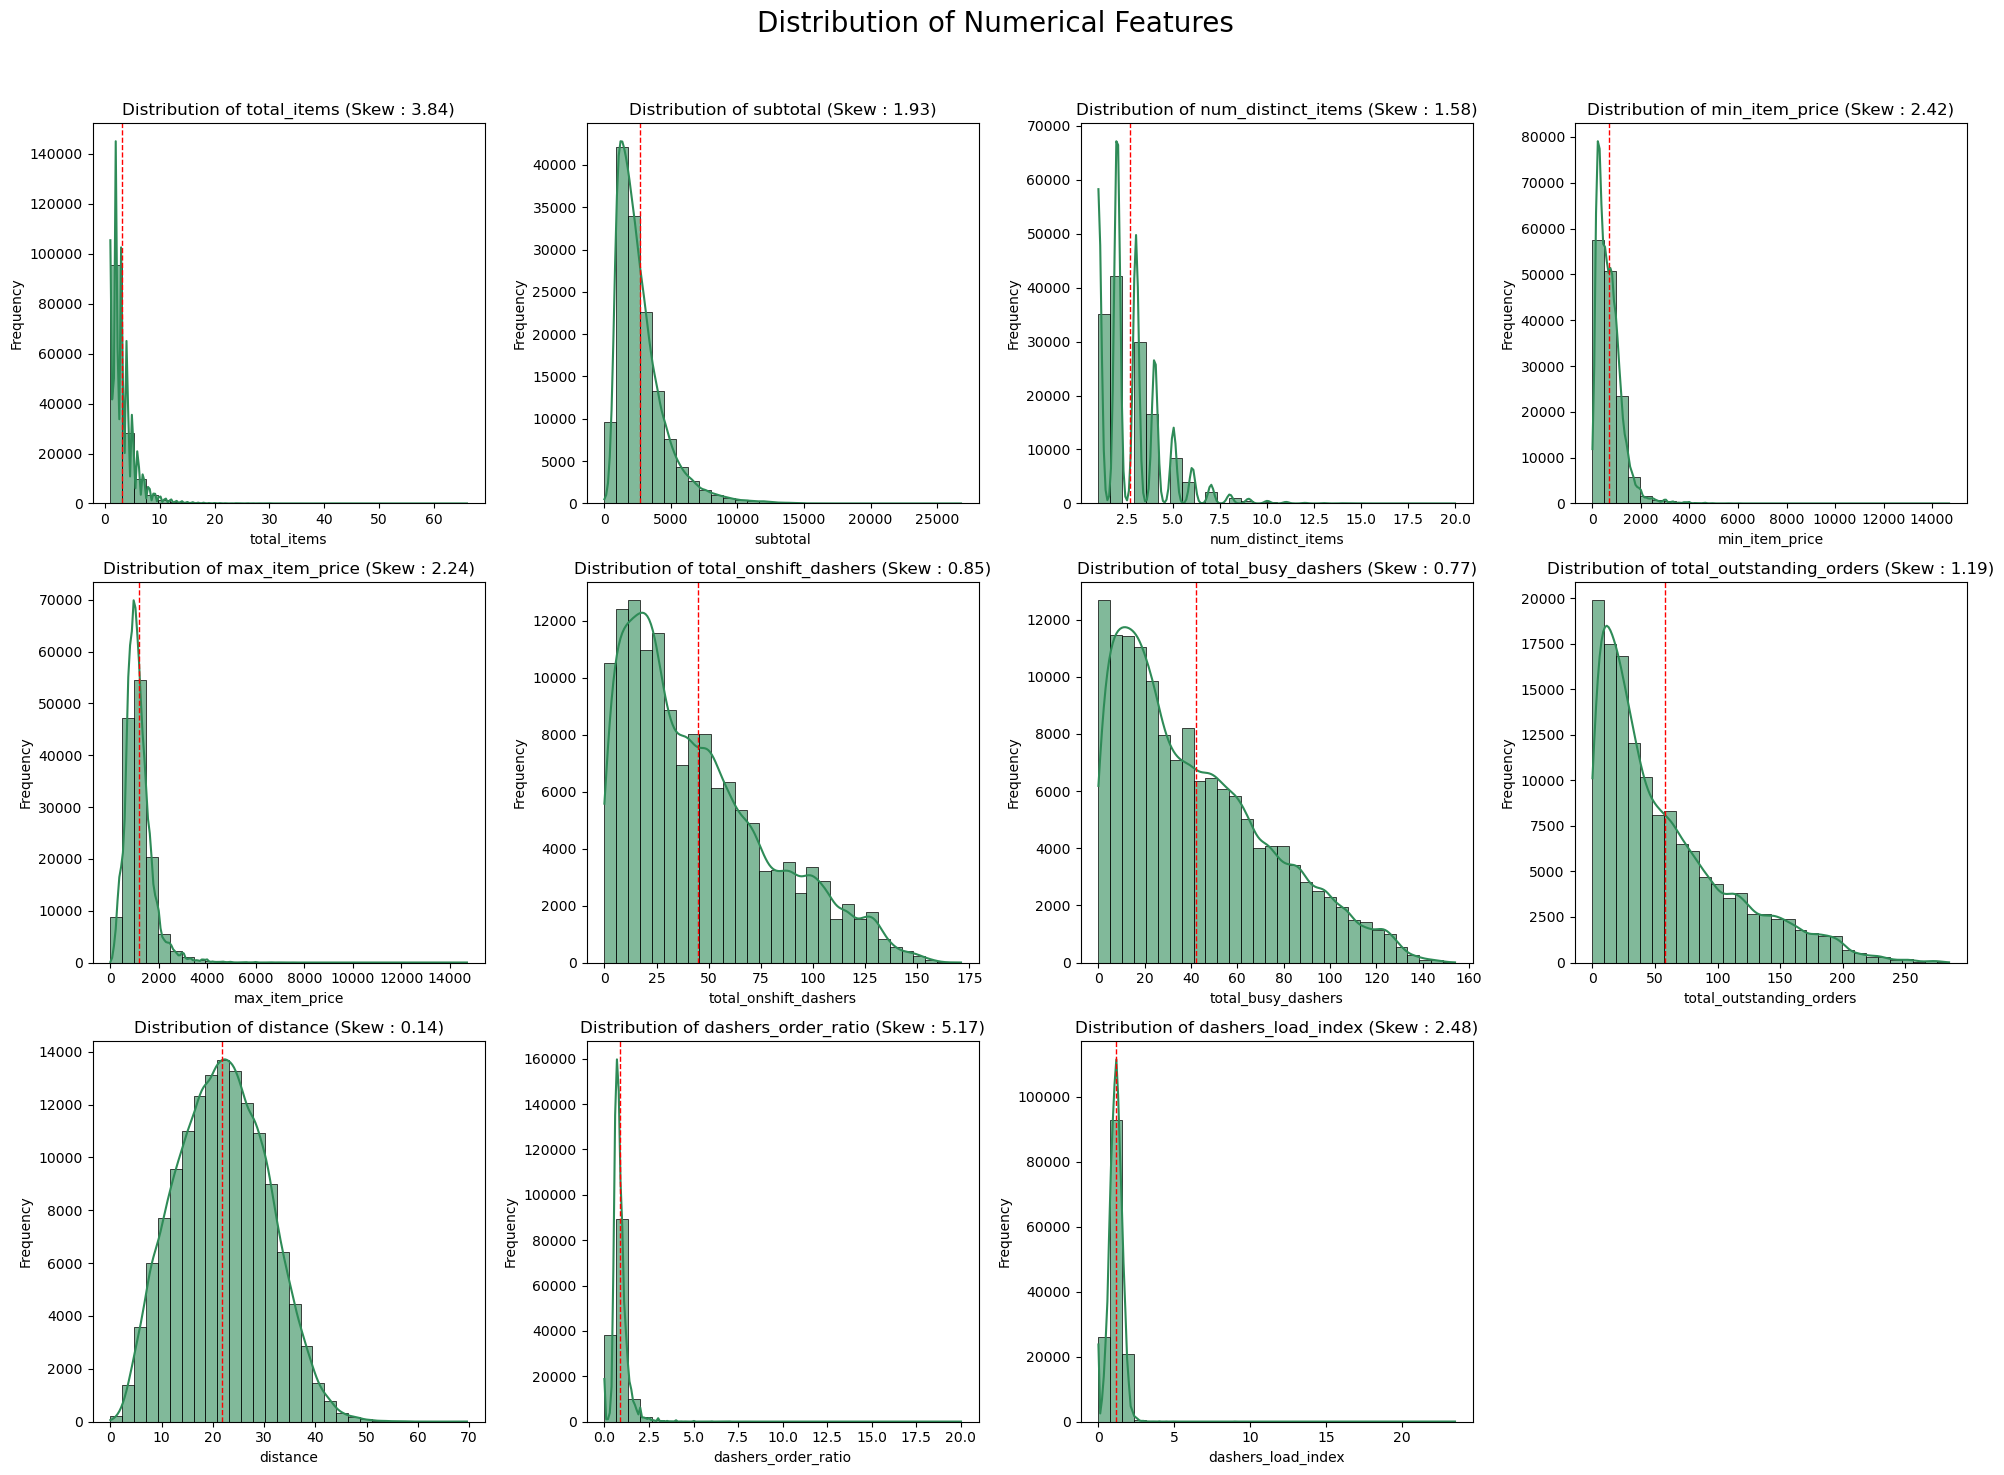

In [237]:
# Plot distributions for all numerical columns
plt.figure(figsize=(20, 15))
for i, col in enumerate(numerical_cols, 1):
    plt.subplot(3,4, i)
    sns.histplot(X_train[col], kde=True, bins=30, color='#2E8B57', alpha=0.6,edgecolor='black', linewidth=0.5)
    plt.axvline(X_train[col].mean(), color='red', linestyle='dashed', linewidth=1, label='Mean')
    plt.title(f'Distribution of {col} (Skew : {X_train[col].skew():.2f})')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.suptitle('Distribution of Numerical Features\n\n', fontsize=20)
plt.tight_layout()
plt.show()


**<span style="color:red">**Observations:**</span>** <span style="color:green">**Suyash Nagar**</span>


- `Total Items (Skew: 26.80)` :Highly right-skewed, meaning most orders contain a few items, while a small number of orders have many.
- `Subtotal (Skew: 1.92)` :Right-skewed, indicating that lower subtotal amounts are more common.
- `Number of Distinct Items (Skew: 1.58)` :Right-skewed, showing most orders contain only a few different items.
- `Max Number of Distinct Items (Skew: 1.55)` :Right-skewed, indicating that most orders have a limited number of distinct items.
- `Min Item Price (Skew: 2.25)` :Right-skewed, meaning most orders include at least one low-priced item.
- `Max Item Price (Skew: 2.13)` :Right-skewed, indicating that maximum prices vary widely, but most stay in a lower range.
- `Total Onshift Dashers (Skew: 0.86)` :Moderately skewed, suggesting fewer dashers are typically available.
- `Total Busy Dashers (Skew: 0.78)` :Moderately skewed, meaning busy dashers are fairly common, but extreme congestion is less frequent.
- `Total Outstanding Orders (Skew: 1.19)` :Right-skewed, showing fewer outstanding orders are the norm. 
- `Distance (Skew: 0.14)` :Nearly symmetric, meaning orders tend to be evenly spread across distances.
- `Time Taken (Skew: 0.76)` :Moderately skewed, indicating most deliveries occur within a predictable timeframe.
- `Dashers Orer Ratio` :Highly RightSkewed, 
- `Day of the Week (Skew: -0.17)` :Right Skewed, moderate load index, but some order with significant high value

**Key Takeaways*
- Many variables show right-skewed distributions, meaning lower values are more common.
- Order sizes, item prices, and subtotal amounts tend to be small, with occasional large orders.
- Delivery distances and time taken appear fairly balanced, supporting consistent serviceability.

##### **3.1.2** <font color = red>[2 marks]</font> <br>
Check the distribution of categorical features

In [238]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 140549 entries, 110609 to 122021
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   market_id                 140549 non-null  category
 1   store_primary_category    140549 non-null  category
 2   order_protocol            140549 non-null  category
 3   total_items               140549 non-null  int64   
 4   subtotal                  140549 non-null  int64   
 5   num_distinct_items        140549 non-null  int64   
 6   min_item_price            140549 non-null  int64   
 7   max_item_price            140549 non-null  int64   
 8   total_onshift_dashers     140549 non-null  int32   
 9   total_busy_dashers        140549 non-null  int32   
 10  total_outstanding_orders  140549 non-null  int32   
 11  distance                  140549 non-null  float64 
 12  dashers_order_ratio       140549 non-null  float64 
 13  dashers_load_index        140

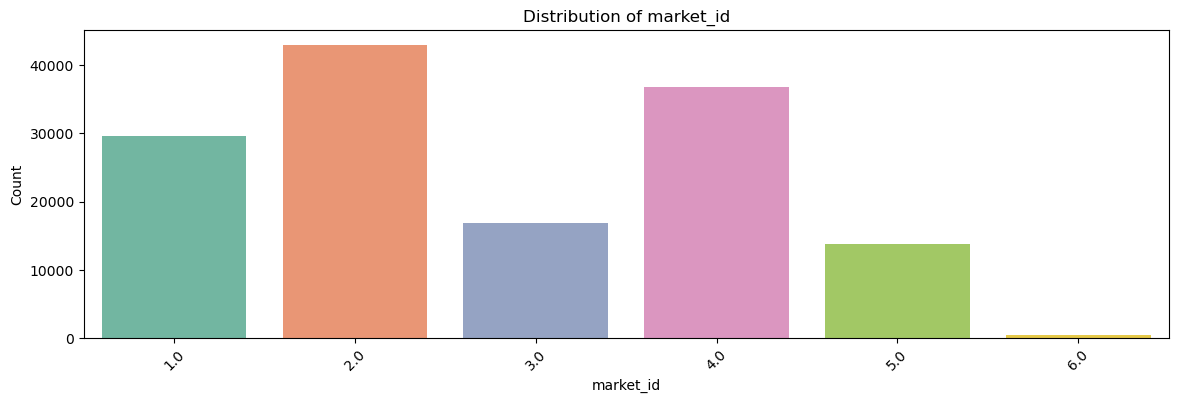

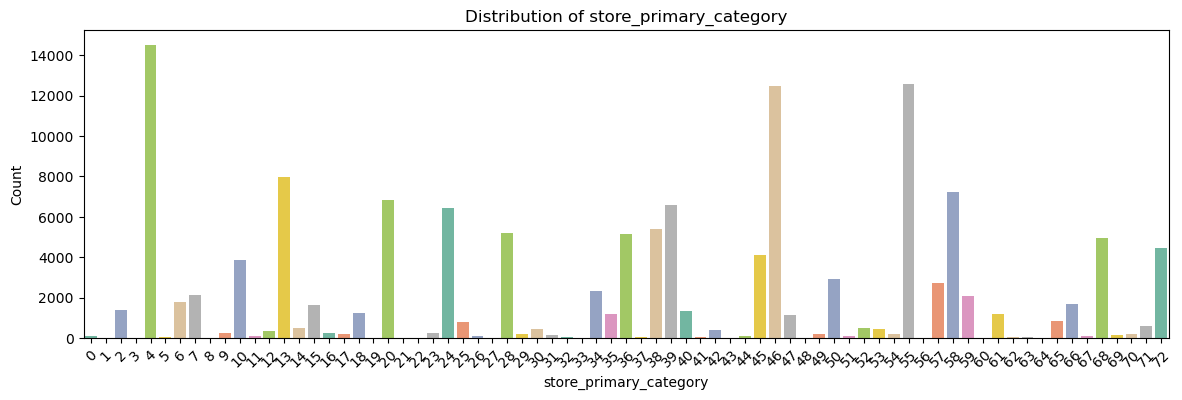

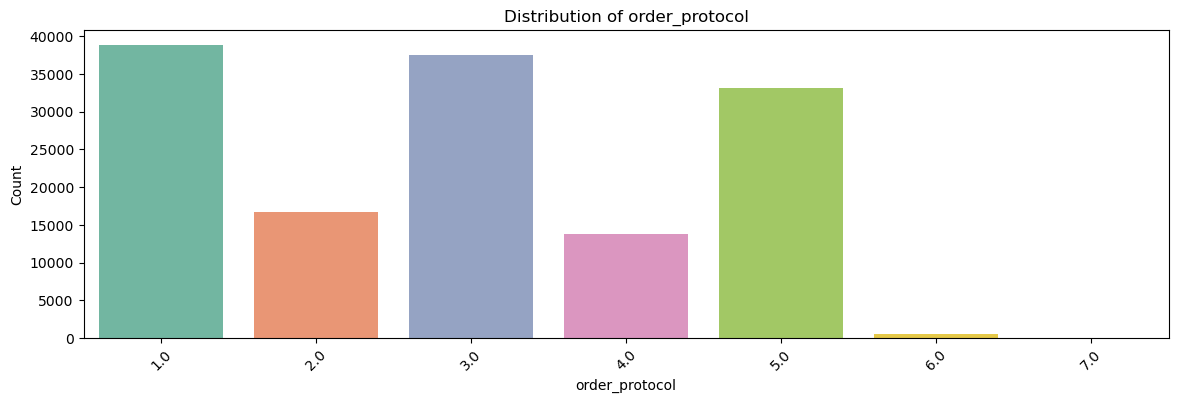

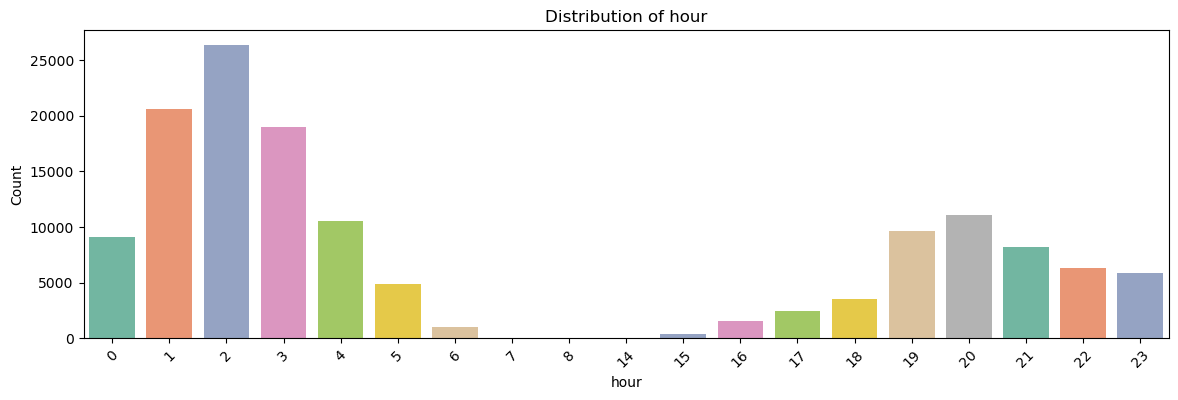

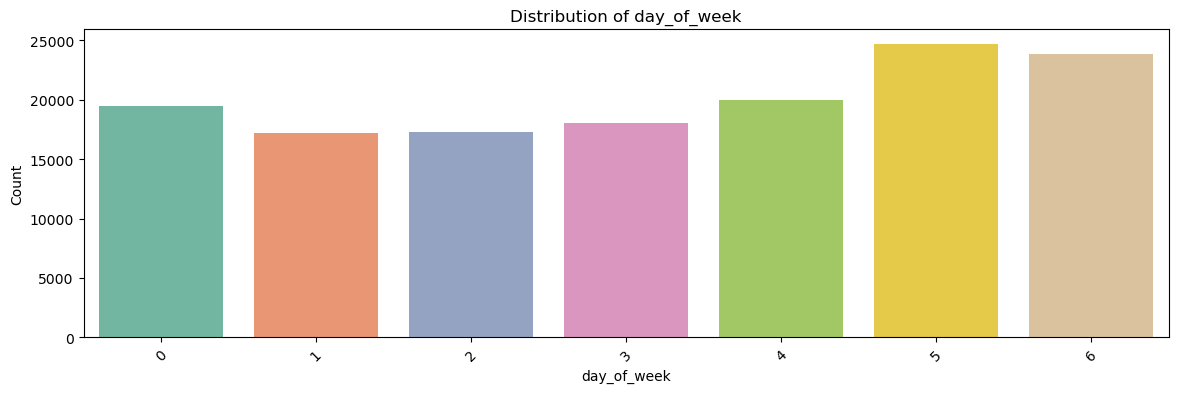

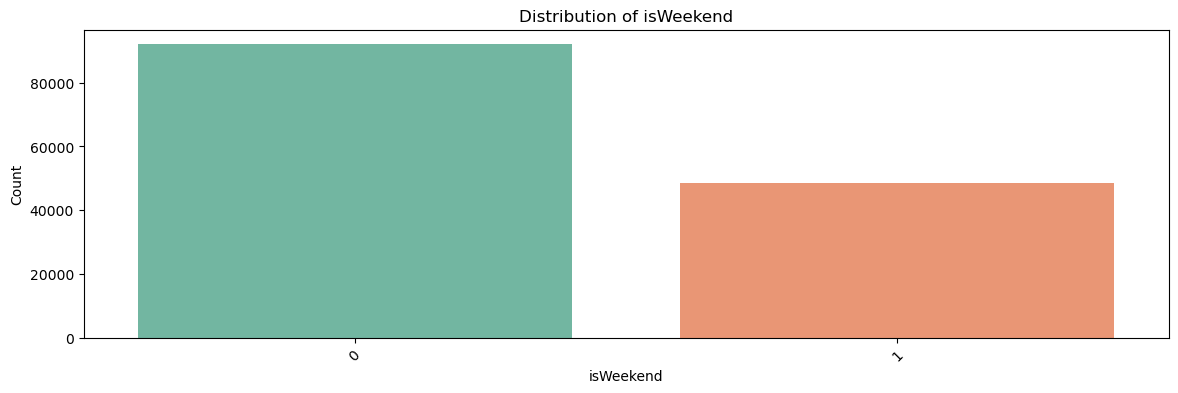

In [239]:
# Distribution of categorical columns
for i, col in enumerate(categorical_cols, 1):
    plt.figure(figsize=(14, 4))
    sns.countplot(data=X_train, x=col, palette='Set2')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.show()


**<span style="color:red">**Data Overview and Observations:**</span>** <span style="color:green">**Suyash Nagar**</span>


- `Market Id`: **Market Id 2** has the largest share followed by **market id 4** where as **market id 6** has the least counts
- `Store Primary Category`: **Category 4** is the most dominant with 14000+ counts followed by **55 and 46**.
                            Distribution varies signifiantly and might suggest some categories are popular and widely available then others. 
- `Order protocol` :**Protocol 1** is the most used with close to 40000 counts followed by **protocol 2 and 3**
- `Day of Week (Monday(0)-->Sunday(6))` Weekend peak starting **Friday** followed by **Saturday** and **Sunday**,other days are steady


##### **3.1.3** <font color = red>[2 mark]</font> <br>
Visualise the distribution of the target variable to understand its spread and any skewness

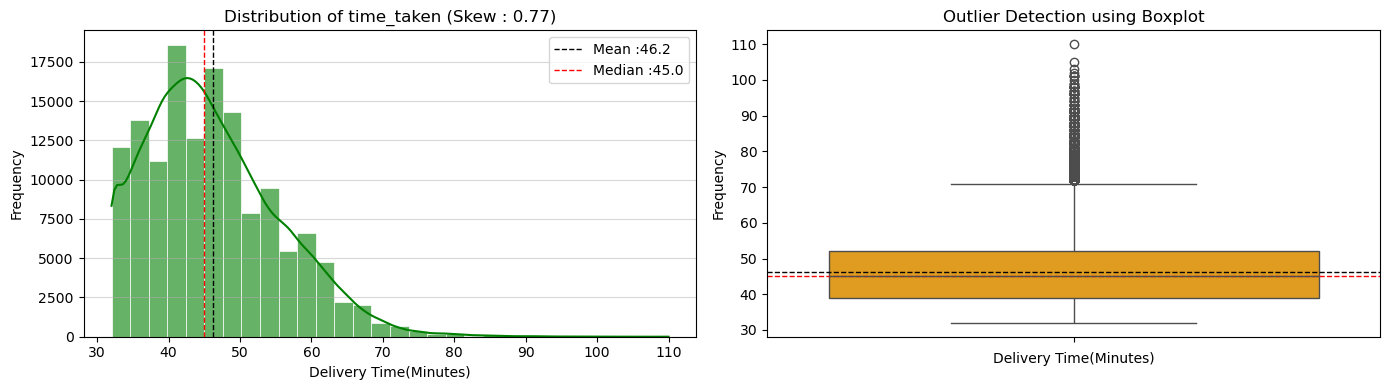

In [240]:
# Distribution of time_taken
plt.figure(figsize=(14, 4))
plt.subplot(1, 2, 1)
sns.histplot(y_train, kde=True, bins=30, color='green', alpha=0.6,edgecolor='white', linewidth=0.5 )
plt.axvline(y_train.mean(), color='black', linestyle='dashed', linewidth=1, label=f'Mean :{y_train.mean():.1f}') #Mean
plt.axvline(y_train.median(), color='red', linestyle='dashed', linewidth=1, label=f'Median :{y_train.median():.1f}') #Median
plt.title('Distribution of time_taken (Skew : {:.2f})'.format(y_train.skew()))
plt.xlabel('Delivery Time(Minutes)')
plt.ylabel('Frequency')
plt.grid(axis='y',alpha=0.5)
plt.legend()


#outlier detection using boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y_train,color='orange')
plt.axhline(y_train.mean(), color='black', linestyle='dashed', linewidth=1, label=f'Mean :{y_train.mean():.1f}') #Mean
plt.axhline(y_train.median(), color='red', linestyle='dashed', linewidth=1, label=f'Median :{y_train.median():.1f}') #Median
plt.title('Outlier Detection using Boxplot')
plt.xlabel('Delivery Time(Minutes)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


**<span style="color:red">**Data Overview and Observations:**</span>** <span style="color:green">**Suyash Nagar**</span>


- `Delivery Time`: 
    - **Right Skewed** more delivery with shorter time and few take much longer time 
    - Mean **46.2** and Median **45** are close, suggesting balanced distribution 
    -**Box plot** indicates existence of outliers above **upper whiskers** indicating longer delivers 

- `Key take aways`:
    - Most deliveries take around 45 minutes 
    - Presence of outliers 

#### **3.2 Relationships Between Features** <font color = red>[3 marks]</font> <br>

##### **3.2.1** <font color = red>[3 marks]</font> <br>
Scatter plots for important numerical and categorical features to observe how they relate to `time_taken`

In [241]:
# Scatter plot to visualise the relationship between time_taken and other features
plt.figure(figsize=(20, 15))
plt.suptitle('Scatter plots of Numerical Features vs time_taken', fontsize=20)
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 4, i+1)
    sns.scatterplot(x=X_train[col], y=y_train,color='purple', alpha=0.6)
    plt.axhline(y_train.median(), color='black', linestyle='dashed', linewidth=1, label=f'Median :{y_train.median():.1f}') #Median
    plt.axhline(y_train.mean(), color='black', linestyle='dashed', linewidth=1, label=f'Mean :{y_train.mean():.1f}') #Mean
    plt.title(f'Scatter plot of {col} vs time_taken')
    plt.xlabel(col)
    plt.ylabel('Delivery Time(Minutes)')
    plt.legend()
    
plt.tight_layout()
plt.show()


In [242]:
X_train['num_distinct_items'].corr(y_train)


0.311606667988449

**<span style="color:red">**Data Overview and Observations:**</span>** <span style="color:green">**Suyash Nagar**</span>


- `Total Items vs Delivery Time`: A slight upward trend, might suggest more items might lead to longer delivery time  
- `Subtotal vs Delivery Time`: No strong correlation, indicating that higher value doesnt mean longer delivery time   
- `Distinct Items vs. Delivery Time`:A weak positive relationship, suggesting that orders with more variety of items could take longer to prepare and deliver.
- `Min Item Price vs. Delivery Time`: Minimal correlation, meaning cheaper or expensive items don’t significantly affect delivery time.
- `Max Item Price vs. Delivery Time`:Similar to the above—delivery times remain fairly consistent across different price ranges.
- `Total Onshift Dashers vs. Delivery Time`:More dashers appear to slightly reduce delivery times, confirming higher availability leads to efficiency.
- `Total Busy Dashers vs. Delivery Time`:Busier dashers correlate with higher delivery times, indicating congestion or peak-hour delays.

- `Outstanding Orders vs. Delivery Time`:Strong correlation with delivery times—more pending orders cause delays, highlighting rush-hour pressure.

- `Distance vs. Delivery Time`:Direct positive correlation—longer distances increase delivery time, as expected.

- `Hour of the Day vs. Delivery Time`:Peak-hour orders show higher delivery times, likely due to demand surges and traffic.

`Key Takeaways`
- Order complexity (distinct items) can extend delivery times.
- Rush-hour congestion affects efficiency, leading to longer deliveries.
- More dashers help, but only when demand is balanced.
- Distance remains a primary determinant of delivery time.




In [243]:
# Show the distribution of time_taken for different hours
plt.figure(figsize=(14, 4))

sns.boxplot(x=X_train['hour'], y=y_train, palette='viridis', showfliers=True,
            flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markeredgecolor': 'black', 'markersize': 3})

plt.title("Delivery Time Distribution by Order Hour")
plt.xlabel("Order Hour (0-23)")
plt.ylabel("Delivery Time (minutes)")
plt.grid(axis='y', alpha=0.3)

# Add median labels
hours = sorted(X_train['hour'].unique())
medians = [y_train[X_train['hour'] == h].median() for h in hours]
for i, m in enumerate(medians):
    plt.text(i, m+1, f'{m:.0f}', ha='center', color='darkred', fontsize=8, fontweight='bold')

plt.show()



**<span style="color:red">**Data Overview and Observations:**</span>** <span style="color:green">**Suyash Nagar**</span>

- `Median Delivery Time`: Ranges from **39 to 50**
- `Outliers`: There are noticeable outliers in multiple hours, suggesting occasional extreme delivery times.

#### **3.3 Correlation Analysis** <font color = red>[5 marks]</font> <br>
Check correlations between numerical features to identify which variables are strongly related to `time_taken`

##### **3.3.1** <font color = red>[3 marks]</font> <br>
Plot a heatmap to display correlations

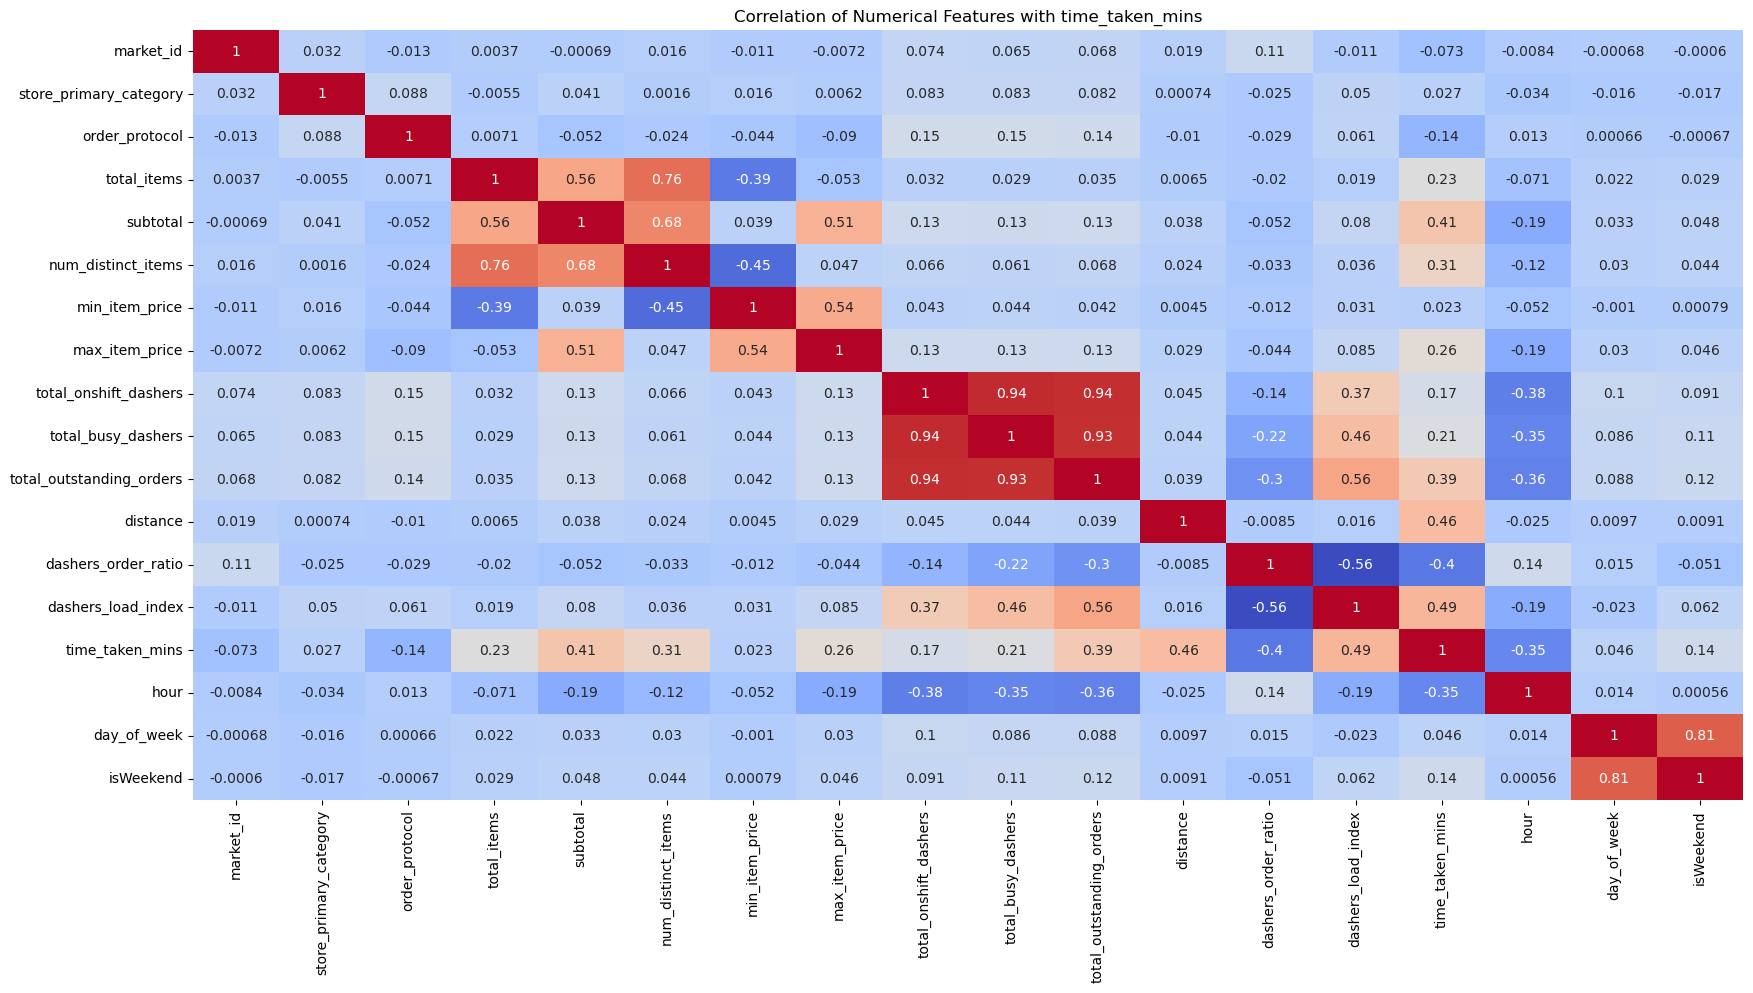

In [244]:
# Plot the heatmap of the correlation matrix
plt.figure(figsize=(20,10))
sns.heatmap( porter_df.corr(),  annot=True, cmap='coolwarm', cbar=False)
plt.title('Correlation of Numerical Features with time_taken_mins')
plt.show()


In [245]:
X_train.head(10)

market_id store_primary_category order_protocol  total_items  subtotal  \
110609       4.0                     46            3.0            6      2980   
171156       3.0                     55            3.0            2      3998   
141352       2.0                     46            5.0            1       699   
37170        1.0                     55            1.0            1       894   
80311        2.0                     36            3.0            5      2785   
48106        5.0                     46            1.0            4      2906   
80461        4.0                     52            3.0            6      6675   
22282        2.0                     13            3.0            2      1490   
3314         1.0                     55            1.0            3      3400   
22828        2.0                     24            1.0            2      2690   

        num_distinct_items  min_item_price  max_item_price  \
110609                   3             150             595   
171156                   2             999             999   
141352                   1             699             699   
37170                    1             695             695   
80311                    4             300             795   
48106                    3             379             999   
80461                    6             395            1595   
22282                    2             495             995   
3314                     2             579             877   
22828                    2             695            1995   

        total_onshift_dashers  total_busy_dashers  total_outstanding_orders  \
110609                     49                  49                        87   
171156                     42                  35                        36   
141352                     86                  82                       106   
37170                      53                  55                        56   
80311                      44                  34                        40   
48106                      20                  19                        15   
80461                      77                  77                       104   
22282                       9                   4                         4   
3314                       22                  17                        21   
22828                      40                  36                        75   

        distance  dashers_order_ratio  dashers_load_index hour day_of_week  \
110609     23.12             0.556818            1.740000    2           0   
171156     25.00             1.135135            0.837209    1           4   
141352     14.92             0.803738            1.218391    1           5   
37170      35.40             0.929825            1.037037    0           6   
80311      25.04             1.073171            0.888889    1           4   
48106      25.60             1.250000            0.714286   20           6   
80461      38.40             0.733333            1.333333    1           2   
22282      17.92             1.800000            0.400000   17           3   
3314       19.12             1.000000            0.913043    5           4   
22828      19.08             0.526316            1.829268    2           6   

       isWeekend  
110609         0  
171156         0  
141352         1  
37170          1  
80311          0  
48106          1  
80461          0  
22282          0  
3314           0  
22828          1

In [246]:
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist() #Numerical columns
#numerical_cols = ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'distance', 'dashers_order_ratio', 'dashers_load_index']
numerical_cols

['total_items',
 'subtotal',
 'num_distinct_items',
 'min_item_price',
 'max_item_price',
 'total_onshift_dashers',
 'total_busy_dashers',
 'total_outstanding_orders',
 'distance',
 'dashers_order_ratio',
 'dashers_load_index']

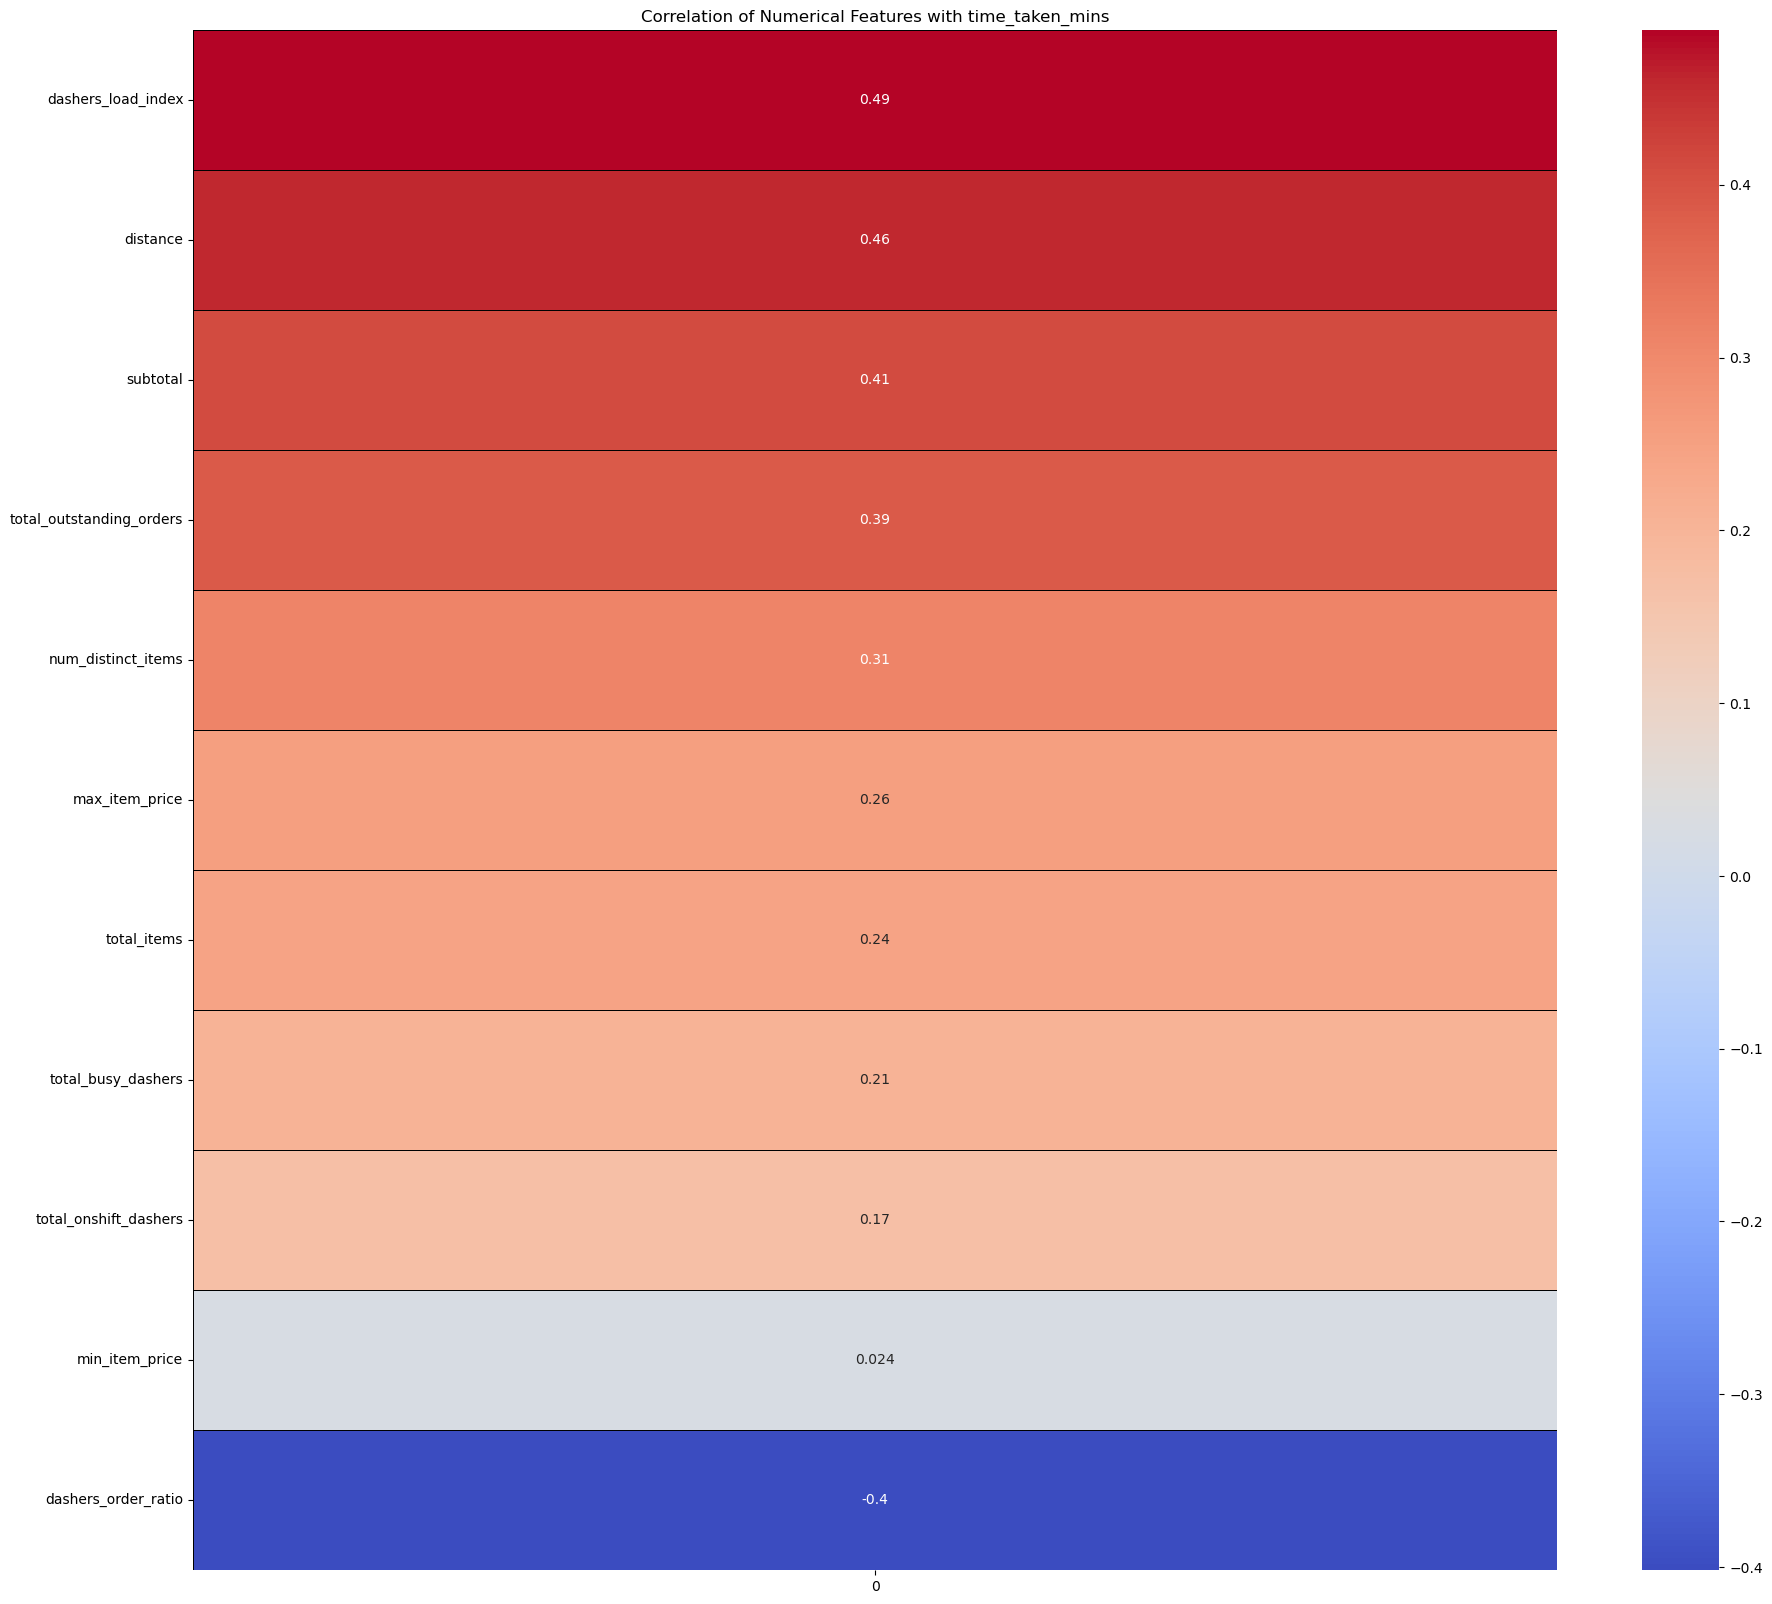

In [247]:
plt.figure(figsize=(22,20))
corr_matrix = X_train[numerical_cols].corrwith(y_train).sort_values(ascending=False)  #Calclulate correlation matrix and sort values by time_taken_mins
sns.heatmap(corr_matrix.to_frame(), annot=True, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black')
plt.title('Correlation of Numerical Features with time_taken_mins')
plt.show()


**<span style="color:red">**Data Overview and Observations:**</span>** <span style="color:green">**Suyash Nagar**</span>

Correlation Heatmap Key Highlights

**Strongest Positive Correlations**

`Dashers Load Index (0.49)`: This is the highest among the features and suggests that when the dashers are under more load, the delivery time tends to increase. This factor may capture real-life constraints such as peak busy times or operational pressure.

`Distance (0.46)`: A higher distance unsurprisingly correlates with longer delivery times. The nearly linear relationship echoes that delivery time is largely influenced by how far the package has to travel.

`Subtotal (0.41)` and `Total Outstanding Orders (0.39)`: These features are moderately correlated with delivery time. A higher order value (subtotal) might indicate larger or more complex orders, while higher outstanding orders could imply operational bottlenecks that inadvertently slow down delivery.

**Moderate to Weak Positive Correlations**

`Number of Distinct Items (0.31)`, `Max Item Price (0.26)`, `Total Items (0.24)`, `Total Busy Dashers (0.21)`, `Total On-Shift Dashers (0.17)`: These features show that while there is some relationship with delivery time, their influence is less pronounced compared to distance or load index. They might affect the delivery time in nuanced ways (e.g., the order complexity or product variety) and could interact with other factors.

**Negative Correlation:**

`Dashers Order Ratio (-0.4)`: This negative correlation suggests that a higher dashers order ratio is associated with shorter delivery times. Perhaps when more dashers are assigned relative to orders, the system can handle orders more swiftly.

##### **3.3.2** <font color = red>[2 marks]</font> <br>
Drop the columns with weak correlations with the target variable

In [248]:
X_train.columns

Index(['market_id', 'store_primary_category', 'order_protocol', 'total_items',
       'subtotal', 'num_distinct_items', 'min_item_price', 'max_item_price',
       'total_onshift_dashers', 'total_busy_dashers',
       'total_outstanding_orders', 'distance', 'dashers_order_ratio',
       'dashers_load_index', 'hour', 'day_of_week', 'isWeekend'],
      dtype='object')

In [249]:
# Drop 3-5 weakly correlated columns from training dataset
week_corr_cols = ['min_item_price', 'total_onshift_dashers','total_busy_dashers','dashers_order_ratio']
X_train.drop(week_corr_cols, axis=1, inplace=True) #training dataset
X_test.drop(week_corr_cols, axis=1, inplace=True) #testing dataset
# Validate the changes in the dataset
print(f"X Train shape: {X_train.shape}, y Train shape: {y_train.shape}")
print(f"X Test shape: {X_test.shape}, y Test shape: {y_test.shape}")



X Train shape: (140549, 13), y Train shape: (140549,)
X Test shape: (35138, 13), y Test shape: (35138,)


#### **3.4 Handling the Outliers** <font color = red>[5 marks]</font> <br>



##### **3.4.1** <font color = red>[2 marks]</font> <br>
Visualise potential outliers for the target variable and other numerical features using boxplots

In [250]:
#update Numerical and Categorical columsn after dropping weekly correlated columns
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist() #Numerical columns
categorical_cols = X_train.select_dtypes(include=['category']).columns.tolist() #Categorical columns
print(f"Numerical columns: {numerical_cols}\n")
print(f"Categorical columns: {categorical_cols}\n")

Numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_outstanding_orders', 'distance', 'dashers_load_index']

Categorical columns: ['market_id', 'store_primary_category', 'order_protocol', 'hour', 'day_of_week', 'isWeekend']



In [251]:
# Boxplot for time_taken
plt.figure(figsize=(12, 3))
sns.boxplot(x=y_train, palette="Set2",showfliers=True,
            flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markeredgecolor': 'black', 'markersize': 3})
plt.title('Boxplot of time_taken_mins')
plt.xlabel('time_taken_mins')
plt.show()




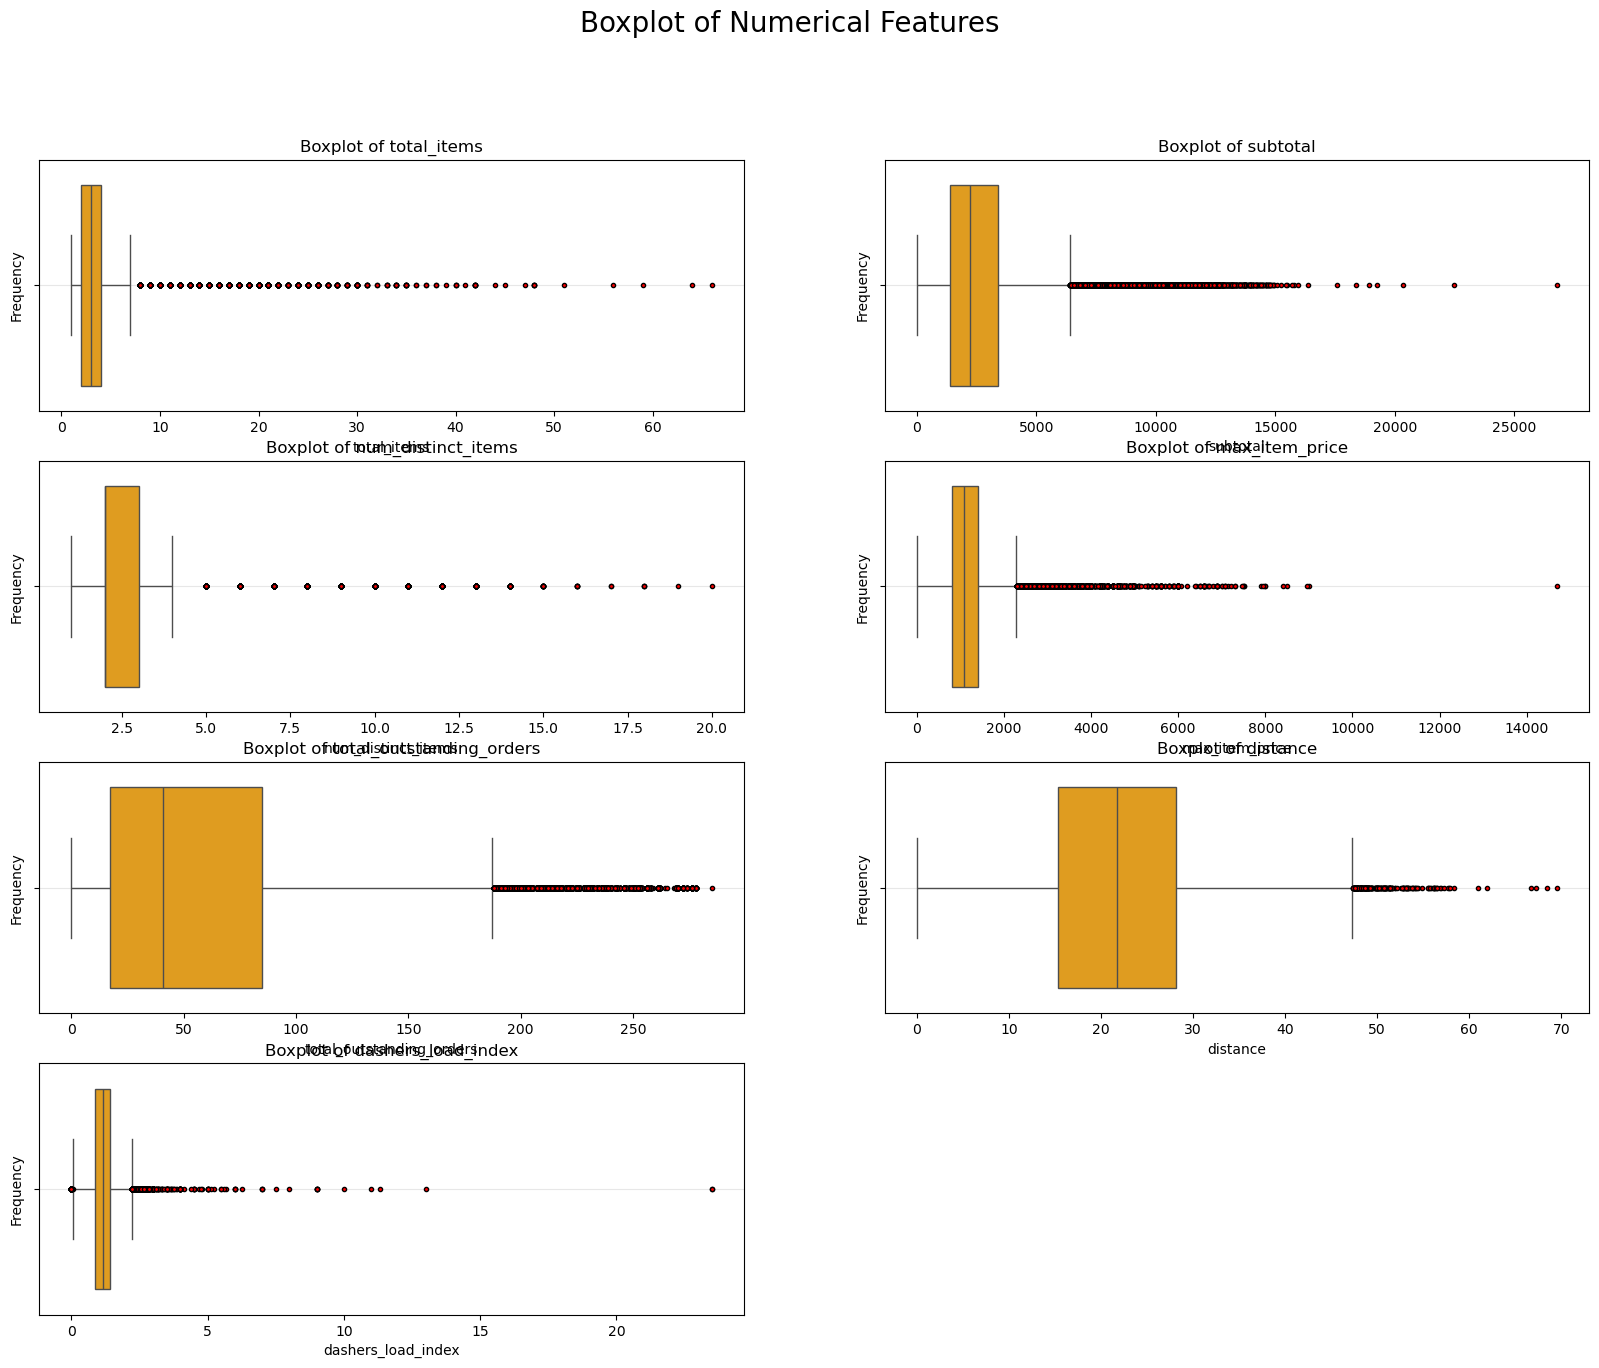

In [252]:
#outlier detection using boxplot for numerical columns
plt.figure(figsize=(20, 15))
plt.suptitle('Boxplot of Numerical Features', fontsize=20)
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x=X_train[col], color='orange',showfliers=True,
                flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markeredgecolor': 'black', 'markersize': 3})
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.3)

##### **3.4.2** <font color = red>[3 marks]</font> <br>
Handle outliers present in all columns

In [253]:
# Handle outliers

# Apply IQR method for continuous variables
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

for col in numerical_cols:
    X_train = remove_outliers_iqr(X_train, col) # Remove outliers from training set
    X_test = remove_outliers_iqr(X_test, col) # Apply the same to test set
    print(f"Removed outliers from {col}")

Removed outliers from total_items
Removed outliers from subtotal
Removed outliers from num_distinct_items
Removed outliers from max_item_price
Removed outliers from total_outstanding_orders
Removed outliers from distance
Removed outliers from dashers_load_index


In [254]:
# Reset indices to align X_train/y_train and X_test/y_test after outlier removal
y_train = y_train.loc[X_train.index]
y_test = y_test.loc[X_test.index]

In [255]:
# Boxplot for time_taken
plt.figure(figsize=(12, 3))
sns.boxplot(x=y_train, color='orange',showfliers=True,
            flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markeredgecolor': 'black', 'markersize': 3})
plt.title('Boxplot of time_taken_mins')
plt.xlabel('time_taken_mins')
plt.show()


In [256]:

#Verify after removing outliers 
X_train[numerical_cols].describe() #Check the summary statistics of numerical columns after removing outliers

total_items       subtotal  num_distinct_items  max_item_price  \
count  116454.000000  116454.000000       116454.000000   116454.000000   
mean        2.724561    2290.937589            2.403181     1075.361619   
std         1.459517    1209.362729            1.226365      394.345088   
min         1.000000       0.000000            1.000000        0.000000   
25%         2.000000    1345.000000            1.000000      799.000000   
50%         2.000000    2035.000000            2.000000     1029.000000   
75%         4.000000    3000.000000            3.000000     1300.000000   
max         7.000000    6070.000000            6.000000     2239.000000   

       total_outstanding_orders       distance  dashers_load_index  
count             116454.000000  116454.000000       116454.000000  
mean                  53.632336      21.740443            1.133561  
std                   45.013801       8.672585            0.370991  
min                    1.000000       0.000000            0.071429  
25%                   18.000000      15.240000            0.875000  
50%                   39.000000      21.720000            1.134831  
75%                   79.000000      28.040000            1.382609  
max                  184.000000      47.320000            2.173077

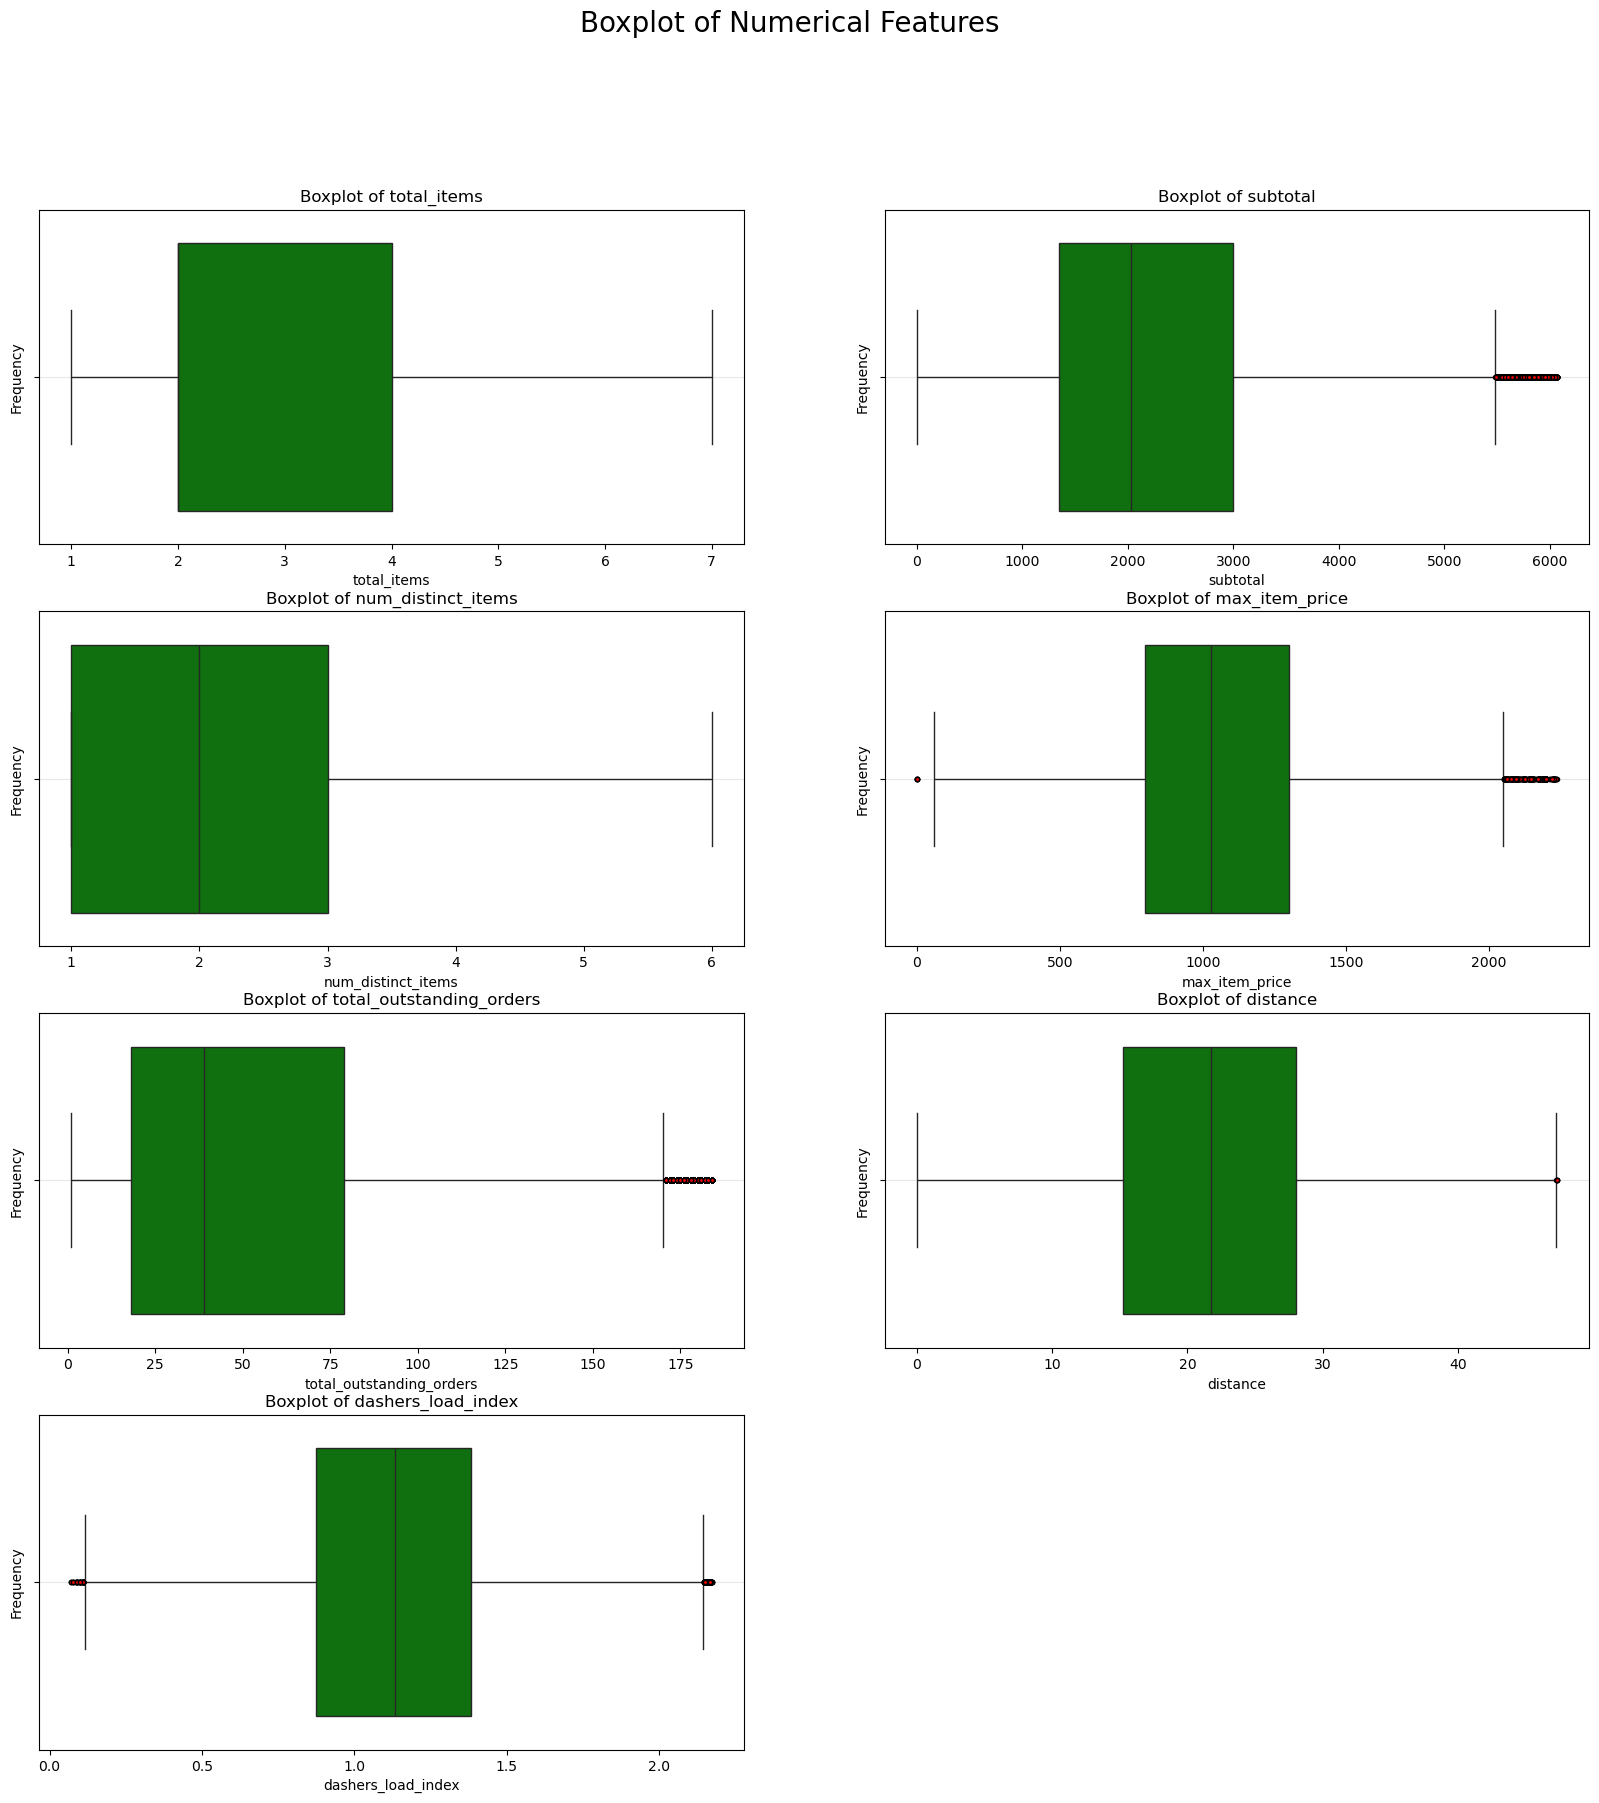

In [257]:
#outlier detection using boxplot for numerical columns
plt.figure(figsize=(20, 20))
plt.suptitle('Boxplot of Numerical Features', fontsize=20)
for i, col in enumerate(numerical_cols):
    plt.subplot(4, 2, i+1)
    sns.boxplot(x=X_train[col], color='green',showfliers=True,
                flierprops={'marker': 'o', 'markerfacecolor': 'red', 'markeredgecolor': 'black', 'markersize': 3})
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.3)

**<span style="color:red">**Data Overview and Observations:**</span>** <span style="color:green">**Suyash Nagar**</span>

Key Observations: **Outliers** removed from **numerical** columns

## **4. Exploratory Data Analysis on Validation Data** <font color = red>[optional]</font> <br>
Optionally, perform EDA on test data to see if the distribution match with the training data

In [258]:
# Define numerical and categorical columns for easy EDA and data manipulation



#### **4.1 Feature Distributions**


##### **4.1.1**
Plot distributions for numerical columns in the validation set to understand their spread and any skewness

In [259]:
# Plot distributions for all numerical columns



##### **4.1.2**
Check the distribution of categorical features

In [260]:
# Distribution of categorical columns



##### **4.1.3**
Visualise the distribution of the target variable to understand its spread and any skewness

In [261]:
# Distribution of time_taken



#### **4.2 Relationships Between Features**
Scatter plots for numerical features to observe how they relate to each other, especially to `time_taken`

In [262]:
# Scatter plot to visualise the relationship between time_taken and other features



#### **4.3** Drop the columns with weak correlations with the target variable

In [263]:
# Drop the weakly correlated columns from training dataset



## **5. Model Building** <font color = red>[15 marks]</font> <br>

#### **Import Necessary Libraries**

In [264]:
# Import libraries



In [265]:
# Define numerical and categorical columns for easy EDA and data manipulation
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist() #Numerical columns
categorical_cols = X_train.select_dtypes(include=['category']).columns.tolist() #Categorical columns
print(f"Numerical columns: {numerical_cols}\n")
print(f"Categorical columns: {categorical_cols}\n")


Numerical columns: ['total_items', 'subtotal', 'num_distinct_items', 'max_item_price', 'total_outstanding_orders', 'distance', 'dashers_load_index']

Categorical columns: ['market_id', 'store_primary_category', 'order_protocol', 'hour', 'day_of_week', 'isWeekend']



In [266]:
X_train_Bck1 = X_train.copy()
X_test_Bck1 =X_test.copy()

In [267]:
#Create dummies for store_primary_category Training Set 
Store_category_top10 = X_train['store_primary_category'].value_counts().nlargest(20).index.tolist()
top_10_with_spc = [f"SPC_{label}" for label in Store_category_top10]
#create 10 binary variables with updated lables
for label, new_label in zip(Store_category_top10,top_10_with_spc):
    X_train[new_label] = np.where(X_train['store_primary_category'] == label, 1, 0)

# Drop the original categorical column
print(X_train[['store_primary_category'] + top_10_with_spc].head(5))
X_train.drop(columns=['store_primary_category'], inplace=True, axis=1)




       store_primary_category  SPC_4  SPC_46  SPC_55  SPC_13  SPC_58  SPC_20  \
110609                     46      0       1       0       0       0       0   
171156                     55      0       0       1       0       0       0   
141352                     46      0       1       0       0       0       0   
37170                      55      0       0       1       0       0       0   
80311                      36      0       0       0       0       0       0   

        SPC_24  SPC_39  SPC_68  SPC_36  SPC_72  SPC_38  SPC_28  SPC_45  \
110609       0       0       0       0       0       0       0       0   
171156       0       0       0       0       0       0       0       0   
141352       0       0       0       0       0       0       0       0   
37170        0       0       0       0       0       0       0       0   
80311        0       0       0       1       0       0       0       0   

        SPC_10  SPC_50  SPC_57  SPC_34  SPC_59  SPC_7  
110609       0    

In [268]:
#Create dummies for store_primary_category Test Set 
Store_category_top10 = X_test['store_primary_category'].value_counts().nlargest(20).index.tolist()
top_10_with_spc = [f"SPC_{label}" for label in Store_category_top10]
#create 10 binary variables with updated lables
for label, new_label in zip(Store_category_top10,top_10_with_spc):
    X_test[new_label] = np.where(X_test['store_primary_category'] == label, 1, 0)

# Drop the original categorical column
print(X_test[['store_primary_category'] + top_10_with_spc].head(5))
X_test.drop(columns=['store_primary_category'], inplace=True, axis=1)

       store_primary_category  SPC_4  SPC_46  SPC_55  SPC_13  SPC_58  SPC_20  \
110142                     71      0       0       0       0       0       0   
79473                      45      0       0       0       0       0       0   
69608                      68      0       0       0       0       0       0   
100630                     55      0       0       1       0       0       0   
118518                      4      1       0       0       0       0       0   

        SPC_24  SPC_39  SPC_68  SPC_36  SPC_72  SPC_38  SPC_28  SPC_45  \
110142       0       0       0       0       0       0       0       0   
79473        0       0       0       0       0       0       0       1   
69608        0       0       1       0       0       0       0       0   
100630       0       0       0       0       0       0       0       0   
118518       0       0       0       0       0       0       0       0   

        SPC_10  SPC_50  SPC_57  SPC_34  SPC_7  SPC_59  
110142       0    

In [269]:
#Create dummies for store_primary_category Training Set 
hour_top10 = X_train['hour'].value_counts().nlargest(10).index.tolist()
top_10_with_hrs = [f"Hrs_{label1}" for label1 in hour_top10]

#create 10 binary variables with updated lables
for label1, new_label in zip(hour_top10,top_10_with_hrs):
    X_train[new_label] = np.where(X_train['hour'] == label1, 1, 0)

# Drop the original categorical column
print(X_train[['hour'] + list(top_10_with_hrs)].head(5))
X_train.drop(columns=['hour'], inplace=True, axis=1)


       hour  Hrs_2  Hrs_1  Hrs_3  Hrs_20  Hrs_4  Hrs_19  Hrs_0  Hrs_21  \
110609    2      1      0      0       0      0       0      0       0   
171156    1      0      1      0       0      0       0      0       0   
141352    1      0      1      0       0      0       0      0       0   
37170     0      0      0      0       0      0       0      1       0   
80311     1      0      1      0       0      0       0      0       0   

        Hrs_22  Hrs_23  
110609       0       0  
171156       0       0  
141352       0       0  
37170        0       0  
80311        0       0  


In [270]:
#Create dummies for store_primary_category Test Set 
hour_top10 = X_test['hour'].value_counts().nlargest(10).index.tolist()
top_10_with_hrs = [f"Hrs_{label1}" for label1 in hour_top10]

#create 10 binary variables with updated lables
for label1, new_label in zip(hour_top10,top_10_with_hrs):
    X_test[new_label] = np.where(X_test['hour'] == label1, 1, 0)

# Drop the original categorical column
print(X_test[['hour'] + list(top_10_with_hrs)].head(5))
print(X_test[['hour'] + list(top_10_with_hrs)].head(5))
X_test.drop(columns=['hour'], inplace=True, axis=1)

       hour  Hrs_2  Hrs_1  Hrs_3  Hrs_20  Hrs_4  Hrs_19  Hrs_0  Hrs_21  \
110142    4      0      0      0       0      1       0      0       0   
79473     3      0      0      1       0      0       0      0       0   
69608     4      0      0      0       0      1       0      0       0   
100630   21      0      0      0       0      0       0      0       1   
118518    5      0      0      0       0      0       0      0       0   

        Hrs_22  Hrs_23  
110142       0       0  
79473        0       0  
69608        0       0  
100630       0       0  
118518       0       0  
       hour  Hrs_2  Hrs_1  Hrs_3  Hrs_20  Hrs_4  Hrs_19  Hrs_0  Hrs_21  \
110142    4      0      0      0       0      1       0      0       0   
79473     3      0      0      1       0      0       0      0       0   
69608     4      0      0      0       0      1       0      0       0   
100630   21      0      0      0       0      0       0      0       1   
118518    5      0      0      0   

In [271]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116454 entries, 110609 to 122021
Data columns (total 41 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   market_id                 116454 non-null  category
 1   order_protocol            116454 non-null  category
 2   total_items               116454 non-null  int64   
 3   subtotal                  116454 non-null  int64   
 4   num_distinct_items        116454 non-null  int64   
 5   max_item_price            116454 non-null  int64   
 6   total_outstanding_orders  116454 non-null  int32   
 7   distance                  116454 non-null  float64 
 8   dashers_load_index        116454 non-null  float64 
 9   day_of_week               116454 non-null  category
 10  isWeekend                 116454 non-null  category
 11  SPC_4                     116454 non-null  int32   
 12  SPC_46                    116454 non-null  int32   
 13  SPC_55                    116

In [272]:
#Check this again
#create dummies for categorical variables
X_train = pd.get_dummies(X_train, columns=['market_id','order_protocol','day_of_week'], drop_first=True,dtype='int')
X_test = pd.get_dummies(X_test, columns=['market_id','order_protocol','day_of_week'], drop_first=True,dtype='int')


In [273]:
x_train_cols=X_train.columns.tolist() #Get the columns of X_train after creating dummies

In [274]:
num=['total_items','subtotal','num_distinct_items','max_item_price','distance' ,'dashers_load_index','total_outstanding_orders']

In [275]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_mean=True, with_std=True)  # Standardize without shifting mean
X_train[num] = scaler.fit_transform(X_train[num])
X_test[num] = scaler.fit_transform(X_test[num])


In [276]:
X_train.head(5)

total_items  subtotal  num_distinct_items  max_item_price  \
110609     2.244204  0.569776            0.486659       -1.218130   
171156    -0.496441  1.411545           -0.328762       -0.193642   
141352    -1.181602 -1.316350           -1.144184       -0.954401   
37170     -1.181602 -1.155107           -1.144184       -0.964544   
80311      1.559042  0.408533            1.302081       -0.710958   

        total_outstanding_orders  distance  dashers_load_index isWeekend  \
110609                  0.741279  0.159072            1.634651         0   
171156                 -0.391711  0.375848           -0.798814         0   
141352                  1.163374 -0.786441            0.228658         1   
37170                   0.052599  1.575034           -0.260180         1   
80311                  -0.302849  0.380460           -0.659512         0   

        SPC_4  SPC_46  SPC_55  SPC_13  SPC_58  SPC_20  SPC_24  SPC_39  SPC_68  \
110609      0       1       0       0       0       0       0       0       0   
171156      0       0       1       0       0       0       0       0       0   
141352      0       1       0       0       0       0       0       0       0   
37170       0       0       1       0       0       0       0       0       0   
80311       0       0       0       0       0       0       0       0       0   

        SPC_36  SPC_72  SPC_38  SPC_28  SPC_45  SPC_10  SPC_50  SPC_57  \
110609       0       0       0       0       0       0       0       0   
171156       0       0       0       0       0       0       0       0   
141352       0       0       0       0       0       0       0       0   
37170        0       0       0       0       0       0       0       0   
80311        1       0       0       0       0       0       0       0   

        SPC_34  SPC_59  SPC_7  Hrs_2  Hrs_1  Hrs_3  Hrs_20  Hrs_4  Hrs_19  \
110609       0       0      0      1      0      0       0      0       0   
171156       0       0      0      0      1      0       0      0       0   
141352       0       0      0      0      1      0       0      0       0   
37170        0       0      0      0      0      0       0      0       0   
80311        0       0      0      0      1      0       0      0       0   

        Hrs_0  Hrs_21  Hrs_22  Hrs_23  market_id_2.0  market_id_3.0  \
110609      0       0       0       0              0              0   
171156      0       0       0       0              0              1   
141352      0       0       0       0              1              0   
37170       1       0       0       0              0              0   
80311       0       0       0       0              1              0   

        market_id_4.0  market_id_5.0  market_id_6.0  order_protocol_2.0  \
110609              1              0              0                   0   
171156              0              0              0                   0   
141352              0              0              0                   0   
37170               0              0              0                   0   
80311               0              0              0                   0   

        order_protocol_3.0  order_protocol_4.0  order_protocol_5.0  \
110609                   1                   0                   0   
171156                   1                   0                   0   
141352                   0                   0                   1   
37170                    0                   0                   0   
80311                    1                   0                   0   

        order_protocol_6.0  order_protocol_7.0  day_of_week_1  day_of_week_2  \
110609                   0                   0              0              0   
171156                   0                   0              0              0   
141352                   0                   0              0              0   
37170                    0                   0              0              0   
80311                    0                

In [277]:
print(f'{X_train.shape} rows and {y_train.shape} columns in y_train')
print(f'{X_test.shape} rows and {y_test.shape} columns in y_test')

(116454, 55) rows and (116454,) columns in y_train
(29155, 55) rows and (29155,) columns in y_test


In [278]:
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True,inplace=True)
y_test.reset_index(drop=True,inplace=True) 



#### **5.1 Feature Scaling** <font color = red>[3 marks]</font> <br>

Note that linear regression is agnostic to feature scaling. However, with feature scaling, we get the coefficients to be somewhat on the same scale so that it becomes easier to compare them.

#### **5.2 Build a linear regression model** <font color = red>[5 marks]</font> <br>

You can choose from the libraries *statsmodels* and *scikit-learn* to build the model.

In [279]:
# Create/Initialise the model
X_train_sm = sm.add_constant(X_train) 
X_test_sm = sm.add_constant(X_test)
# Train the model using the training data
model = sm.OLS(y_train, X_train_sm).fit()
print(model.summary()) # Print the summary of the model

#predict for this model 
y_train_pred = model.predict(X_train_sm)
y_test_pred = model.predict(X_test_sm)

# Calculate R-squared for training set
r2_score_train = r2_score(y_train, y_train_pred) # R-squared for training set
print(f"R-squared for training set: {r2_score_train:.4f}") # Print R-squared for training set

# Calculate R-squared value for test set
r2_test = r2_score(y_test, y_test_pred) # R-squared value for test set
print(f"R-squared value - Test Set : {r2_test:.4f}") # R-squared value


                            OLS Regression Results                            
Dep. Variable:        time_taken_mins   R-squared:                       0.785
Model:                            OLS   Adj. R-squared:                  0.785
Method:                 Least Squares   F-statistic:                     7856.
Date:                Tue, 29 Apr 2025   Prob (F-statistic):               0.00
Time:                        19:30:24   Log-Likelihood:            -3.2265e+05
No. Observations:              116454   AIC:                         6.454e+05
Df Residuals:                  116399   BIC:                         6.459e+05
Df Model:                          54                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [280]:
# Train the model using the training data
columns_with_high_pvalue = model.pvalues[model.pvalues > 0.05].index.tolist()
print(columns_with_high_pvalue)

['isWeekend', 'SPC_55', 'SPC_58', 'SPC_24', 'SPC_39', 'SPC_45', 'SPC_50', 'SPC_57', 'order_protocol_7.0']


In [281]:

vif_data = pd.DataFrame()
vif_data["feature"] = X_train_sm.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)
vif_data[vif_data["VIF"] >5]

feature        VIF
55  day_of_week_6        inf
8       isWeekend        inf
54  day_of_week_5        inf
0           const  34.456916
1     total_items   6.398721

Note that we have 12 (depending on how you select features) training features. However, not all of them would be useful. Let's say we want to take the most relevant 8 features.

We will use Recursive Feature Elimination (RFE) here.

For this, you can look at the coefficients / p-values of features from the model summary and perform feature elimination, or you can use the RFE module provided with *scikit-learn*.

#### **5.3 Build the model and fit RFE to select the most important features** <font color = red>[7 marks]</font> <br>

For RFE, we will start with all features and use
the RFE method to recursively reduce the number of features one-by-one.

After analysing the results of these iterations, we select the one that has a good balance between performance and number of features.

In [282]:
X_train_sm= X_train_sm.drop(columns=['const'],axis=1) # Drop the constant column
X_test_sm= X_test_sm.drop(columns=['const'],axis=1) # Drop the constant column

In [283]:
# Loop through the number of features and test the model
estimator = LinearRegression()
selector = RFE(estimator, n_features_to_select=12, step=1) # Recursive Feature Elimination
selector = selector.fit(X_train_sm, y_train) # Fit the model
# Get the ranking of features
ranking = selector.ranking_ # Get the ranking of features
selected_features = X_train_sm.columns[selector.support_].tolist() # Get the selected features
print(f"Selected features: {selected_features}") # Print the selected features


Selected features: ['distance', 'dashers_load_index', 'Hrs_20', 'Hrs_19', 'Hrs_21', 'Hrs_22', 'Hrs_23', 'market_id_2.0', 'market_id_3.0', 'market_id_4.0', 'market_id_5.0', 'market_id_6.0']


In [284]:
X_train.shape

(116454, 55)

In [285]:
X_train_sm.shape


(116454, 55)

In [286]:
best_r2 = float("-inf")
best_result = {}
all_features = X_train.columns

# Loop through all combinations of exactly 8 features
combination_id = 0
for feature_subset in combinations(selected_features, 8):#replaced all_feature with selected feature
    combination_id += 1
    # Select subset of features
    X_train_subset = X_train[list(feature_subset)]
    X_test_subset = X_test[list(feature_subset)]
    
    # Train the model {r2_score_train:.4f}
    model = LinearRegression()
    model.fit(X_train_subset, y_train)

    # Make predictions
    y_pred = model.predict(X_test_subset)

    # Evaluate performance
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f'{combination_id} | {feature_subset} | {round(mae,4)}| {round(mse,4)} | {round(r2,4)}')


print("Done")


1 | ('distance', 'dashers_load_index', 'Hrs_20', 'Hrs_19', 'Hrs_21', 'Hrs_22', 'Hrs_23', 'market_id_2.0') | 3.8465| 23.9635 | 0.6448
2 | ('distance', 'dashers_load_index', 'Hrs_20', 'Hrs_19', 'Hrs_21', 'Hrs_22', 'Hrs_23', 'market_id_3.0') | 4.184| 27.4118 | 0.5937
3 | ('distance', 'dashers_load_index', 'Hrs_20', 'Hrs_19', 'Hrs_21', 'Hrs_22', 'Hrs_23', 'market_id_4.0') | 4.1799| 27.3871 | 0.594
4 | ('distance', 'dashers_load_index', 'Hrs_20', 'Hrs_19', 'Hrs_21', 'Hrs_22', 'Hrs_23', 'market_id_5.0') | 4.1637| 27.2799 | 0.5956
5 | ('distance', 'dashers_load_index', 'Hrs_20', 'Hrs_19', 'Hrs_21', 'Hrs_22', 'Hrs_23', 'market_id_6.0') | 4.1927| 27.5148 | 0.5921
6 | ('distance', 'dashers_load_index', 'Hrs_20', 'Hrs_19', 'Hrs_21', 'Hrs_22', 'market_id_2.0', 'market_id_3.0') | 3.8762| 24.2525 | 0.6405
7 | ('distance', 'dashers_load_index', 'Hrs_20', 'Hrs_19', 'Hrs_21', 'Hrs_22', 'market_id_2.0', 'market_id_4.0') | 3.7487| 22.6536 | 0.6642
8 | ('distance', 'dashers_load_index', 'Hrs_20', 'Hrs_19'

In [287]:
shortlisted_feature=['distance', 'dashers_load_index', 'Hrs_20', 'Hrs_19', 'Hrs_21', 'Hrs_22', 'market_id_2.0', 'market_id_4.0']

In [288]:
X_train_sm = X_train_sm[shortlisted_feature]
X_test_sm=X_test_sm[shortlisted_feature]

In [289]:
X_train_sm = sm.add_constant(X_train_sm) 
X_test_sm = sm.add_constant(X_test_sm)
model1_4 = sm.OLS(np.array(y_train), X_train_sm).fit() # Create the model
print(model1_4.summary()) # Print the summary of the model
# Make predictions
y_train_pred = model1_4.predict(X_train_sm) # Predictions on training set
y_test_pred = model1_4.predict(X_test_sm) # Predictions on test set
# Calculate R-squared for training set
r2_score_train = r2_score(y_train, y_train_pred) # R-squared for training set
print(f"R-squared for training set: {r2_score_train:.4f}") # Print R-squared for training set
# Calculate R-squared value for test set
r2_test = r2_score(y_test, y_test_pred) # R-squared value for test set
print(f"R-squared value - Test Set : {r2_test:.4f}") # R-squared value

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.671
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                 2.965e+04
Date:                Tue, 29 Apr 2025   Prob (F-statistic):               0.00
Time:                        19:31:44   Log-Likelihood:            -3.4738e+05
No. Observations:              116454   AIC:                         6.948e+05
Df Residuals:                  116445   BIC:                         6.949e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 48.2367      0

In [290]:


vif_data = pd.DataFrame()
vif_data["feature"] = X_train_sm.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_sm.values, i) for i in range(X_train_sm.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False)
vif_data[vif_data["VIF"] >5]

Empty DataFrame
Columns: [feature, VIF]
Index: []

In [291]:
#Metrices  - Training
print(f"MAE: {mean_absolute_error(y_train, y_train_pred):.2f}")
print(f"MSE: {mean_squared_error(y_train, y_train_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_train_pred)):.2f}")
print(f"R²: {r2_score(y_train, y_train_pred):.4f}")


MAE: 3.75
MSE: 22.83
RMSE: 4.78
R²: 0.6707


In [292]:
#Metrices  - Test
print(f"MAE: {mean_absolute_error(y_test, y_test_pred):.2f}")
print(f"MSE: {mean_squared_error(y_test, y_test_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_test_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_test_pred):.4f}")

MAE: 3.75
MSE: 22.65
RMSE: 4.76
R²: 0.6642


## **6. Results and Inference** <font color = red>[5 marks]</font> <br>

#### **6.1 Perform Residual Analysis** <font color = red>[3 marks]</font> <br>

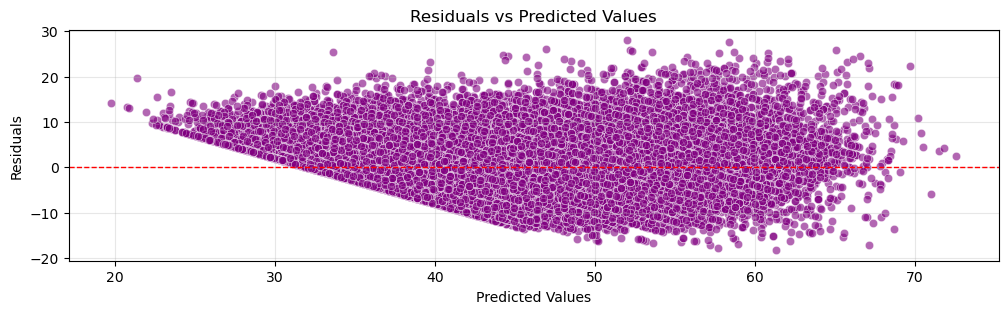

<Figure size 1400x300 with 0 Axes>

In [293]:
# Perform residual analysis using plots like residuals vs predicted values, Q-Q plot and residual histogram

residuals = y_train - y_train_pred # Calculate residuals
plt.figure(figsize=(12, 3))
sns.scatterplot(x=y_train_pred, y=residuals, color='purple', alpha=0.6)
plt.axhline(0, color='red', linestyle='dashed', linewidth=1) # Add a horizontal line at 0
plt.title('Residuals vs Predicted Values')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(alpha=0.3)

# Q-Q plot for normality of residuals
plt.figure(figsize=(14, 3))
sm.qqplot(residuals, line='s')
plt.title('Q-Q Plot of Residuals')
plt.grid(alpha=0.3)


# Histogram of residuals
plt.figure(figsize=(12, 3))
sns.histplot(residuals, kde=True, bins=30, color='purple', alpha=0.6, edgecolor='black', linewidth=0.5)
plt.axvline(residuals.mean(), color='red', linestyle='dashed', linewidth=1, label='Mean') # Mean
plt.axvline(residuals.median(), color='black', linestyle='dashed', linewidth=1, label='Median') # Median
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')


plt.tight_layout()
plt.show()



**<span style="color:red">**Data Overview and Observations:**</span>** <span style="color:green">**Suyash Nagar**</span>

**1. Residuals vs PRedicted Values**
    The Residuals are random scatter and centered around Zero, suggests the model    captures the systematic part of data well.

**Q-Q Plot** 
    Residuals mostly align with red reference line which represent theory of a normal distribution indicative of, residuals are approximately normally distributed 
    
**Residual histogram**
    The residuals are approximately symmetric around zero and closely follow a normal distribution, as indicated by the smooth overlaid curve. The dashed vertical lines, likely representing measures of central tendency, confirm that most errors center near zero

**Overall, these plot supports the assumption of normality in the error terms—a key requirement in linear regression—for reliable inference and model performance.**




[Your inferences here:]



#### **6.2 Perform Coefficient Analysis** <font color = red>[2 marks]</font> <br>

Perform coefficient analysis to find how changes in features affect the target.
Also, the features were scaled, so interpret the scaled and unscaled coefficients to understand the impact of feature changes on delivery time.


In [294]:
X_train_sm.drop(columns='const',axis=1,inplace=True)

In [295]:
X_train_sm.head(2)

distance  dashers_load_index  Hrs_20  Hrs_19  Hrs_21  Hrs_22  \
0  0.159072            1.634651       0       0       0       0   
1  0.375848           -0.798814       0       0       0       0   

   market_id_2.0  market_id_4.0  
0              0              1  
1              0              0

In [296]:
import pandas as pd
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

# Assume X_train and y_train are already defined. 
# If not, load or prepare your training data accordingly.

# --- Fit the unscaled model ---
# If needed, add a constant for the intercept
X_train_unscaled = sm.add_constant(X_train_sm)
unscaled_model = sm.OLS(y_train, X_train_unscaled).fit()

# --- Fit the scaled model ---
# First, scale the features (excluding the intercept)
scaler = StandardScaler()
X_train_scaled_values = scaler.fit_transform(X_train_sm)
X_train_scaled = pd.DataFrame(X_train_scaled_values, columns=X_train_sm.columns)
# Add constant for the intercept
X_train_scaled = sm.add_constant(X_train_scaled)
scaled_model = sm.OLS(y_train, X_train_scaled).fit()

# --- Compare the coefficients ---
# Create a DataFrame to show coefficients from both models
coeff_df = pd.DataFrame({
    "Features": ["Intercept"] + list(X_train_sm.columns),
    "Unscaled Coeff": unscaled_model.params.values,
    "Scaled Coeff": scaled_model.params.values
})

print(coeff_df)


             Features  Unscaled Coeff  Scaled Coeff
0           Intercept       48.236717     44.612946
1            distance        4.221033      4.221033
2  dashers_load_index        4.900068      4.900068
3              Hrs_20       -4.635766     -1.301344
4              Hrs_19       -3.706996     -0.953842
5              Hrs_21       -4.009153     -0.984431
6              Hrs_22       -2.893637     -0.621141
7       market_id_2.0       -5.559537     -2.562343
8       market_id_4.0       -3.313211     -1.452055


In [297]:
# Define the features and their coefficients (example values)
features = coeff_df['Features']  
unscaled_coeff = coeff_df['Unscaled Coeff']
scaled_coeff   = coeff_df['Scaled Coeff']

# Create an index for the features and define the width of the bars
x = np.arange(len(features))
width = 0.35
# Get a palette for two colors from Seaborn
colors = sns.color_palette("Set2", 2)
# Create the plot
fig, ax = plt.subplots(figsize=(12, 4))
rects1 = ax.bar(x - width/2, unscaled_coeff, width, label='Unscaled Coeff',color=colors[0])
rects2 = ax.bar(x + width/2, scaled_coeff, width, label='Scaled Coeff',color=colors[1])

# Add some text for labels, title and custom x-axis tick labels
ax.set_ylabel('Coefficient Value')
ax.set_title('Comparison of Scaled vs. Unscaled Coefficients')
ax.set_xticks(x)
ax.set_xticklabels(features, rotation=45, ha='right')
ax.legend()

# Optionally, annotate the bars with their values
def annotate_bars(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

annotate_bars(rects1)
annotate_bars(rects2)

plt.tight_layout()
plt.show()


Additionally, we can analyse the effect of a unit change in a feature. In other words, because we have scaled the features, a unit change in the features will not translate directly to the model. Use scaled and unscaled coefficients to find how will a unit change in a feature affect the target.

In [298]:
# Analyze the effect of a unit change in a feature, say 'total_items'

for col in X_train_sm.columns:
    # Retrieve the coefficient corresponding to the feature 'col'
    coef = unscaled_model.params[col]
    print(f"Effect of a unit change in {col} on Delivery Time: {coef:.4f} units")



Effect of a unit change in distance on Delivery Time: 4.2210 units
Effect of a unit change in dashers_load_index on Delivery Time: 4.9001 units
Effect of a unit change in Hrs_20 on Delivery Time: -4.6358 units
Effect of a unit change in Hrs_19 on Delivery Time: -3.7070 units
Effect of a unit change in Hrs_21 on Delivery Time: -4.0092 units
Effect of a unit change in Hrs_22 on Delivery Time: -2.8936 units
Effect of a unit change in market_id_2.0 on Delivery Time: -5.5595 units
Effect of a unit change in market_id_4.0 on Delivery Time: -3.3132 units


Note:
The coefficients on the original scale might differ greatly in magnitude from the scaled coefficients, but they both describe the same relationships between variables.

Interpretation is key: Focus on the direction and magnitude of the coefficients on the original scale to understand the impact of each variable on the response variable in the original units.

Include conclusions in your report document.

## Subjective Questions <font color = red>[20 marks]</font>

Answer the following questions only in the notebook. Include the visualisations/methodologies/insights/outcomes from all the above steps in your report.

#### Subjective Questions based on Assignment

##### **Question 1.** <font color = red>[2 marks]</font> <br>

Are there any categorical variables in the data? From your analysis of the categorical variables from the dataset, what could you infer about their effect on the dependent variable?

**Answer:** <span style="color:green">**Suyash Nagar**</span>

>Yes, there are categorical variables in the porter dataset such as marketid, store_primary_category, order_protocil, day_of_week, isWeekend.

>`Market Id` represting diffrent zones which could impact delivery time, as certain market may have congestion or traffic leading to longer delviery time 

>`Store Primary Category` Type of services offered by store may affect delivery time For instance **Fast Food** might have shorter delviery times compared to restaurants 

>`Order Protocol` Some of protocols as seen in data are heavily used compared to others 

>`Hour` , `Day of week` and `Weekend` Delivery time is affected by all during peak hours or if its weekend 





---



##### **Question 2.** <font color = red>[1 marks]</font> <br>
What does `test_size = 0.2` refer to during splitting the data into training and test sets?

**Answer:** <span style="color:green">**Suyash Nagar**</span>
> Parameter `test_size =0.2` is used for spliting a dataset into training and test sets. It markes the proportions of the data allocated to train and test. when it is **0.2** means **20%** of the total dataset will be used for testing while **80%** for training.

**For example** If datset contains `10000` records then `Test Set` will be **2000** and `Training Set` would be **8000** records.



---



##### **Question 3.** <font color = red>[1 marks]</font> <br>
Looking at the heatmap, which one has the highest correlation with the target variable?  

**Answer:** <span style="color:green">**Suyash Nagar**</span>
> `Distance` and **derived feature** `dashers_load_index` has the strongest positive correlation with target variable `time_taken_mins`, meaning longer distances significantly increase delivery times.



---



##### **Question 4.** <font color = red>[2 marks]</font> <br>
What was your approach to detect the outliers? How did you address them?

**Answer:** <span style="color:green">**Suyash Nagar**</span>

>I have used `IQR` method to detect outliers for each `continuous` variable. I commputed `Q1` and `Q3` followed by `IQR(Q3-Q1)` and defined lower and upper bound as `Q1 - 1.5(IQR)` and `Q3 + 1.5(IQR)`.

Data outside of these bounds were taken as outliers and removed from both `training` and `test` dataset

**Additionally,** Box plots were used to identify outlier visually and at last `describe` function was used to validate 



---



##### **Question 5.** <font color = red>[2 marks]</font> <br>
Based on the final model, which are the top 3 features significantly affecting the delivery time?

**Answer:** <span style="color:green">**Suyash Nagar**</span>
>Top 3 feature significantly affecting the delviery time are 
1. `distance`           Coeffient   4.22 --> For extra unit of distance delviery time is increased by 4.22 minutes
2. `dashers_load_index` Coeffient   4.9  --> If Dashers are loaded then it will affact the delivery time by 4.9 minutes    
3. `Hrs_20`             Coeffient  -1.3  --> Order placed at 8PM, could lead to reduction in delivery time by 1.3 minutes, suggesting faster delivery



---



#### General Subjective Questions

##### **Question 6.** <font color = red>[3 marks]</font> <br>
Explain the linear regression algorithm in detail

**Answer:** <span style="color:green">**Suyash Nagar**</span>
>Linear Regression falls under supervised leanring and it used to build relationship between dependent variable `Target` and independent variables `Features` by fitting Lineaar equation **[y = mX +b]**.

The Goal of `Linear Regression` is to find **best-fit** line that minimizes the error between predicted and actual values.

**Types of Linear Regression**
1. `Simple Linear Regression` (only one independent variable)
2. `Multiple Linear Regression` (Many independent variable) 

**Important Assumptions**
- `Linearity`: Relationship between variable is linear 
- `Independence`: Features are not correlated 
- `Homoscedasticity`: Constant error variance 
- `No Multicollienearity`: Features should not be highly correlated 

**Pros**
-   Easy to interpret.
-   Computationally efficient.

**Cons**
-   Struggles with non-linearity.
-   Sensitive to outliers.






---



##### **Question 7.** <font color = red>[2 marks]</font> <br>
Explain the difference between simple linear regression and multiple linear regression

**Answer:** <span style="color:green">**Suyash Nagar**</span>

>
| Simple Linear Regression                     | Multiple Linear Regression                                                                   |
|----------------------------------------------|---------------------------------------------------------------------------------------------|
|Models the relationship betwen one independent variable (X) and a dependent variable (Y)                                 | Works with two or more independent variables affecting dependent target variable|
| Y= mX + b                                 | Y= b₀ + b₁X₁ + b₂X₂ + ... + bₙXₙ                                                  |
| To be used when there is only single factor affecting the outcome                      | To be used when result is impacted by multiple factors                                  |
| Predict : price of house just based on location                  | Predict: House price based on location, size , area, number of bedrooms etc                                      |
| Complexity is low andinterpretation is easy                            | Complexity is high and require more analysis |




---



##### **Question 8.** <font color = red>[2 marks]</font> <br>
What is the role of the cost function in linear regression, and how is it minimized?

**Answer:** <span style="color:green">**Suyash Nagar**</span>>
> Cost or loss function measures how well the model fits the data by calculating difference between predicted and actual valus. One of the most comman industry metric is Mean Squared Error(MSE).

Cost function can be minimized by using Gradient Desent
- Calculate slope of cost function 
- Adjust model parameters 
- continue updating parameter untile minimum 





---



##### **Question 9.** <font color = red>[2 marks]</font> <br>
Explain the difference between overfitting and underfitting.



**Answer:** <span style="color:green">**Suyash Nagar**</span>

> Overfitting` it occurs when model learns training data too good, including noise. With increased complexity model performs well on training data and poorly on test and unknown data. To simplify models, learn training data instead of learning its patterns.

**Effects of overfitting**
- High accuracy on training but poor performance on test data
- Sensitive to small variations in the data, making it unstable

`Underfitting`: Occures when a model fails to capture the pattern in data, this can be caused if model is too simple and does not observe from training data, leading to poor performance on both training and test data.

**Effects of overfitting**
- Low accuracy on both Train and Test

**How to avoid Overfitting and Underfitting**

`Overfitting`
- Use regularization techniques
- Collect more training data or mockup data(augmentation)
- Reduce model complexity

`Underfitting`
- Train for longer durations 
- Ensure data hygiene 
- Use complex model





---



##### **Question 10.** <font color = red>[3 marks]</font> <br>
How do residual plots help in diagnosing a linear regression model?

**Answer:** <span style="color:green">**Suyash Nagar**</span>
>`Residual plots` visualize the discrepancies between actual and predicted values (the residuals) to help assess key model assumptions and potential issues.

`Linearity`: A good residual plot shows a random scatter of points around zero without any distinct pattern otherwise response is not linear 

`Homoscedasticity`: Constant variance across all levels of predicted values

`Normality of Errors`: Residual plots like histograms or Q-Q plots are used separately, they complement scatter plots to verify whether residuals are approximately normally distributed

To Summarize, `residual plots` provide a visual check for the linear regression assumptions (linearity, constant variance, and normality) and help identify data points that might require further investigation or remediation.

